# Modeling with k-means, Part 1

This project shows how we can use the k-means algorithm to build better classification models than what we can already construct using various supervised learning approaches.  Here I am employing k-means as a supervised learning algorithm, giving it information about the labels indirectly in two distinct ways: (1) through input from one or more supervised learning algorithms in the form of an additional variable, or probability column; and (2) through the addition of weights in the dissimilarity measure, the weights arrived at through cross-validation scores that rely on the labels, or response variable.

Even when k-means is used for unsupervised learning, there are a number of ways we guide, or constrain, the algorithm.  For example, (a) we tell it the number of clusters to find; (b) we select the variables we want the algorithm to work with; and (c) we choose the transformations to apply to those variables.  Variable selection and variable transformations greatly affect the results we see when applying k-means.  The less appropriate the inputs to the algorithm are, the less useful the results will be.  

A fourth way we can guide the algorithm is by applying weights to the variables.  While this is a variant of (c), it deserves its own category because the weights I refer to appear in the object dissimilarity measure---the distance formula.  These weights are used to regulate a variable's relative influence "in determining the overall dissimilarity between objects \[i.e., observations\]" (p.505 of *The Elements of Statistical Learning, Second Edition*, by Hastie, Tibshirani, and Friedman; see Equation (14.24)).  In the modeling that follows, the weight given to a variable depends on the role the variable has, in the presence of the other variables, in partitioning the data into the subgroups that are of interest to us.  Those variables assigned a greater weight are, we might say, more important for correctly identifying these subgroups, while the variables assigned a smaller weight are less important.  But even if we can identify the more important predictors in this sense, it is very likely we will not know what weights to assign unless we have data to work with in which the subgroups of interest are already identified, or labeled.  When k-means is used for unsupervised learning, this information is not available to us.

Sometimes, however, we do have the data we need in order to assign meaningful and relevant weights.  These are the scenarios that are of interest to me in this project.  In other words, we can employ k-means as a supervised learning algorithm.  But rather than directly giving it the labels to train on, we can give it the probability output from one or more other classification algorithms.  Under certain conditions, this hybrid approach yields an even better classifier.  A primary aim of this project is to identify these conditions.

In Part1 I apply this hybrid approach to data on downer cows.  Here the k-means hybrid model outperforms the other classification models surveyed, and weights can be used to improve the model.  In Part2 I apply the hybrid approach to the California housing dataset.  Here optimal weights are much harder to establish (the number of predictors more than doubles, and the amount of training data is 33X greater).  Weights in this example do not help to improve the model by much.  


In Part 4 I work with the Italian wine dataset used by Kabacoff (*R in Action*, p.370); there are 3 varieties to identify.


                                       * * * * *



The downer cow data for Part 1 are introduced on p.266 of Sanford Weisberg's *Applied Linear Regression, 3rd Edition*:

"For unknown reasons, dairy cows sometimes become recumbent---they lay down.  Called *downers*, these cows may have a serious illness that may lead to death of the cow.  These data are from a study of blood samples of over 400 downer cows studied at the Ruakura New Zealand Animal Health Laboratory during 1983-1984.  A variety of blood tests were performed, and for many of the animals, the outcome (survived, died, or animal was killed) was determined.  The goal is to see if survival can be predicted from the blood measurements.  The variables in the data file *downer.txt* are described \[below\].  These data were collected from veterinary records, and not all variables were recorded for all cows."    



                                        * * * * *
                                        

# Section 1: Initial look at the cow data

In this section I look at some of the relationships between the variables in the dataset and choose a subset of the variables for model construction.

In [ ]:
require(car)
require(repr)
require(ggplot2)
require(stringr)
require(faraway)
require(parallel)
require(randomForest)
require(gbm)
require(plyr)
require(e1071)


In [2]:
options(digits= 5, show.signif.stars= FALSE)


In [4]:
df <- read.table("/home/greg/Documents/stat/alr3data/downer.txt", header= TRUE)
dim(df)
colnames(df)


[1] 435   9

[1] "Calving"  "Daysrec"  "CK"       "AST"      "Urea"     "PCV"      "Inflamat"
[8] "Myopathy" "Outcome"

In [ ]:
# Description of the variables in the dataset:


# Outcome : = 1 if the cow survived; 0 if it died or was killed


### Categorical variables:

# Calving : = 0 if measurements were taken before calving; = 1 if taken after.

# Inflamat : Is inflammation present? 0 = no; 1 = yes.

# Myopathy : Is muscle disorder present?  0 = no; 1 = yes.


### Continuous variables:

# Daysrec : days recumbent when measurements were taken.

# CK : serum creatine phosphokinase (in U/l at 30C)

# AST : serum asparate amino transferase (in U/l at 30C)

# Urea : serum ureas (in mmol/l)

# PCV : packed cell volume (hematocrit), percent


In [4]:
# 38% of the 435 cows survived.

table(df$Outcome)
round(mean(df$Outcome, na.rm=TRUE), 4)



  0   1 
269 166 

[1] 0.3816

In [4]:
table(df$Inflamat, useNA= "ifany")



   0    1 <NA> 
  38   98  299 

In [5]:
table(df$Calving, useNA= "ifany")



   0    1 <NA> 
 107  324    4 

In [6]:
table(df$Myopathy, useNA= "ifany")



   0    1 <NA> 
 127   95  213 

In [7]:
summary(df$Daysrec)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   1.000   1.947   3.000  20.000       3 

In [3]:
# Percent of cows recumbent < 1 day.

val <- dim(df[which(df$Daysrec < 1),])[1]
round(val/nrow(df), 3)


[1] 0.308

In [8]:
summary(df$CK)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
     13     560    1760    5352    5467   71000      22 

In [9]:
summary(df$AST)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   33.0   123.0   240.0   398.4   492.0  2533.0       6 

In [10]:
summary(df$Urea)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   5.625   7.600   9.803  10.975  50.000     169 

In [11]:
summary(df$PCV)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  13.00   32.00   35.00   35.56   40.00   61.00     260 

In [1]:
### COMMENTS:

# There is a great deal of missing data for PCV, Urea, Myopathy, 
# and Inflamat.  Because of this, I do not want to include any
# of these variables in my classifiers.  I want to keep as many
# of the 435 records as possible since I will be comparing the 
# performance of different classifiers, and the greater the 
# number of observations I have to work with, the smaller the
# variability in these performance measures.

# The potential remaining predictors, then, are: Calving, Daysrec,
# CK, and AST.


In [5]:
# Function for computing the probability that the response
# variable is 1 given the value of the predictor, its 
# logistic regression coefficient (link =  logit), and
# the coefficient of the intercept.

get_prob <- function(x, coeffs) {
    
    b0 <- as.numeric(coeffs[1])
    b1 <- as.numeric(coeffs[2])
    prob <- (exp(b0 + b1*x)/(1 + exp(b0 + b1*x)))
    return(round(prob, 3))
}


In [15]:
# To what degree does Calving "explain" Outcome?

fit_calv <- glm(Outcome ~ Calving, data=df, family= binomial())
summary(fit_calv)



Call:
glm(formula = Outcome ~ Calving, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.01   -1.01   -0.89    1.35    1.50  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.721      0.206   -3.50  0.00046
Calving        0.321      0.235    1.36  0.17228

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 573.6  on 430  degrees of freedom
Residual deviance: 571.7  on 429  degrees of freedom
  (4 observations deleted due to missingness)
AIC: 575.7

Number of Fisher Scoring iterations: 4


In [32]:
# Is Daysrec a predictor of Outcome?

fit_daysre <- glm(Outcome ~ Daysrec, data=df, family= binomial())
summary(fit_daysre)



Call:
glm(formula = Outcome ~ Daysrec, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.103  -1.034  -0.842   1.254   2.288  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.1782     0.1308   -1.36  0.17311
Daysrec      -0.1689     0.0512   -3.30  0.00097

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 574.57  on 431  degrees of freedom
Residual deviance: 561.62  on 430  degrees of freedom
  (3 observations deleted due to missingness)
AIC: 565.6

Number of Fisher Scoring iterations: 4


In [33]:
# The 3rd quartile for Daysrec is 3.0.  The probability of
# the average downer cow surviving if it has been recumbent 
# for 3 days is around 33%.

get_prob(3.0, fit_daysre$coeff)


[1] 0.335

In [34]:
# The probability that the average cow survives increases as
# the number of days recumbent decreases.

get_prob(0, fit_daysre$coeff)


[1] 0.456

In [ ]:
### COMMENT:

# Since Daysrec is predictive of the outcome, we perhaps
# ought to control for this variable when regressing 
# Outcome on the blood measurements.

# Further downstream I regress CK and AST on Daysrec.
# The results tell us that we should control for
# Daysrec.


In [31]:
# Is Calving predictive when we control for Daysrec?

fit_daysre_calv <- glm(Outcome ~ Daysrec + Calving, data=df,
                       family= binomial())
summary(fit_daysre_calv)



Call:
glm(formula = Outcome ~ Daysrec + Calving, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.146  -1.026  -0.834   1.230   2.468  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.3682     0.2268   -1.62  0.10447
Daysrec      -0.1877     0.0537   -3.49  0.00048
Calving       0.2931     0.2398    1.22  0.22158

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 569.75  on 427  degrees of freedom
Residual deviance: 553.09  on 425  degrees of freedom
  (7 observations deleted due to missingness)
AIC: 559.1

Number of Fisher Scoring iterations: 4


In [3]:
# Function for computing "proportion of deviance explained", an 
# R-sqrd statistic for link= logit.  See p.41 of Julian Faraway's
# "Extending the Linear Model with R" (2006: Chapman & Hall).  
# This statistic is due to N. Nagelkerke (1991; see Faraway's
# bibliography).

get_RsqrdDev <- function(modl) {
    
    n_obs <- length(modl$fitted.values)
    ans <- (1-exp((modl$deviance - modl$null.deviance)/n_obs))/(1-exp(-modl$null.deviance/n_obs))
    return(round(ans, 4))
}


### The blood measurement variables

In [7]:
# Variable CK:

fit_ck <- glm(Outcome ~ I(log(CK)), data= df, family= binomial())
summary(fit_ck)



Call:
glm(formula = Outcome ~ I(log(CK)), family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.134  -0.881  -0.561   1.059   1.994  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   4.0006     0.5809    6.89  5.7e-12
I(log(CK))   -0.6117     0.0793   -7.71  1.2e-14

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.49  on 412  degrees of freedom
Residual deviance: 475.18  on 411  degrees of freedom
  (22 observations deleted due to missingness)
AIC: 479.2

Number of Fisher Scoring iterations: 3


In [38]:
# Variable CK, controlling for Daysrec:

fit_ck_days <- glm(Outcome ~ I(log(CK)) + Daysrec, 
                   data= df, family= binomial())
summary(fit_ck_days)



Call:
glm(formula = Outcome ~ I(log(CK)) + Daysrec, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.195  -0.885  -0.559   1.039   2.072  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   4.0929     0.5887    6.95  3.6e-12
I(log(CK))   -0.5939     0.0805   -7.38  1.6e-13
Daysrec      -0.1330     0.0643   -2.07    0.039

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 546.64  on 409  degrees of freedom
Residual deviance: 465.95  on 407  degrees of freedom
  (25 observations deleted due to missingness)
AIC: 471.9

Number of Fisher Scoring iterations: 3


In [25]:
# Regress CK on Daysrec to see whether the time when the 
# blood measurement was taken matters.

resp_var_pwr <- -0.2

ck_days <- lm(I(CK^resp_var_pwr) ~ Daysrec, data= df)
summary(ck_days)



Call:
lm(formula = I(CK^resp_var_pwr) ~ Daysrec, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1441 -0.0554 -0.0129  0.0452  0.3475 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.25117    0.00529   47.51   <2e-16
Daysrec     -0.00847    0.00214   -3.96    9e-05

Residual standard error: 0.0784 on 408 degrees of freedom
  (25 observations deleted due to missingness)
Multiple R-squared:  0.0369,	Adjusted R-squared:  0.0346 
F-statistic: 15.7 on 1 and 408 DF,  p-value: 8.97e-05


In [ ]:
### COMMENT: 

# Daysrec explains only 3.5% of the variation in CK. 


In [35]:
# Variable AST:

fit_ast <- glm(Outcome ~ I(log(AST)), data= df, family= binomial())
summary(fit_ast)



Call:
glm(formula = Outcome ~ I(log(AST)), family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.889  -0.906  -0.535   1.020   2.357  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    5.407      0.738    7.33  2.4e-13
I(log(AST))   -1.089      0.137   -7.93  2.3e-15

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 569.75  on 428  degrees of freedom
Residual deviance: 489.08  on 427  degrees of freedom
  (6 observations deleted due to missingness)
AIC: 493.1

Number of Fisher Scoring iterations: 4


In [39]:
# Variable AST, controlling for Daysrec:

fit_ast_days <- glm(Outcome ~ I(log(AST)) + Daysrec, 
                    data= df, family= binomial())
summary(fit_ast_days)



Call:
glm(formula = Outcome ~ I(log(AST)) + Daysrec, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.905  -0.896  -0.539   1.005   2.329  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   5.3260     0.7461    7.14  9.4e-13
I(log(AST))  -1.0551     0.1416   -7.45  9.3e-14
Daysrec      -0.0511     0.0488   -1.05     0.29

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 565.90  on 425  degrees of freedom
Residual deviance: 483.99  on 423  degrees of freedom
  (9 observations deleted due to missingness)
AIC: 490

Number of Fisher Scoring iterations: 4


In [ ]:
### COMMENTS:

# We see from the above model that Daysrec and AST
# are doing some of the same work in terms of
# explaining the variance in the response variable.
# The output suggests that we remove Daysrec
# from the model.  As already mentioned, I will keep
# Daysrec in the final model to control for the
# effects of this variable on the measurements of
# both CK and AST.

# Also, having a third dimension is likely to help
# the k-means algorithm and give a boost to the tree
# models examined further downstream.


In [35]:
# Regress AST on Daysrec to see whether the time when the 
# blood measurement was taken matters.

resp_var_pwr <- -0.2

ast_days <- lm(I(AST^resp_var_pwr) ~ Daysrec, data= df)
summary(ast_days)



Call:
lm(formula = I(AST^resp_var_pwr) ~ Daysrec, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13600 -0.04345 -0.00063  0.04520  0.16391 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.35054    0.00374   93.83  < 2e-16
Daysrec     -0.00719    0.00119   -6.04  3.4e-09

Residual standard error: 0.06 on 424 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.0792,	Adjusted R-squared:  0.077 
F-statistic: 36.4 on 1 and 424 DF,  p-value: 3.43e-09


In [ ]:
### COMMENT:

# Daysrec explains around 8% of the variation in AST. 


In [8]:
# See if Calving is needed when the other predictors are
# in the model.

fit_all <- glm(Outcome ~ I(log(AST)) + I(log(CK)) + 
               Daysrec + Calving, 
               data= df, family= binomial())

summary(fit_all)



Call:
glm(formula = Outcome ~ I(log(AST)) + I(log(CK)) + Daysrec + 
    Calving, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.087  -0.899  -0.516   0.975   2.162  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   4.9086     0.7918    6.20  5.7e-10
I(log(AST))  -0.4898     0.2208   -2.22   0.0266
I(log(CK))   -0.3798     0.1233   -3.08   0.0021
Daysrec      -0.0885     0.0690   -1.28   0.1996
Calving       0.2705     0.2725    0.99   0.3209

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 540.83  on 404  degrees of freedom
Residual deviance: 455.66  on 400  degrees of freedom
  (30 observations deleted due to missingness)
AIC: 465.7

Number of Fisher Scoring iterations: 4


In [ ]:
### COMMENTS:

# The above model indicates that Calving is not going
# to help us.  This is OK because the overall aim of 
# this Part1 is not to find the best model for Outcome
# given the original set of predictors.  I just need
# a subset of the predictors to work with; 3 is ideal,
# because this greatly reduces the time needed to find
# weights.  

# (It turns out that, for the purposes of showing the 
# value of a k-means hybrid model, I am actually better 
# off working with a set of predictors which make it 
# difficult for any classifier to have an accuracy score
# greater than around 75-80%.  As the accuracy score of
# a classifier increases, the chances that the k-means
# algorithm will be able to improve upon it decrease.)


In [10]:
# Reduce our dataframe to include only the variables we
# need.  Then remove records with missing values.

dfb <- df[, c("Outcome","Daysrec","CK","AST")]
dfb <- na.omit(dfb)
nrow(dfb)


[1] 408

## Find best logistic regression model for predicting Outcome

In [11]:
# A tentative logistic model.

f03 <- glm(Outcome ~ Daysrec + I(log(CK)) + I(log(AST)),  
            data= dfb, family= binomial())
summary(f03)



Call:
glm(formula = Outcome ~ Daysrec + I(log(CK)) + I(log(AST)), family = binomial(), 
    data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.186  -0.893  -0.523   0.997   2.195  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   5.1704     0.7659    6.75  1.5e-11
Daysrec      -0.0855     0.0689   -1.24   0.2143
I(log(CK))   -0.3882     0.1233   -3.15   0.0016
I(log(AST))  -0.4904     0.2209   -2.22   0.0264

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.76  on 407  degrees of freedom
Residual deviance: 457.50  on 404  degrees of freedom
AIC: 465.5

Number of Fisher Scoring iterations: 4


In [ ]:
### COMMENTS:

# Each of Daysrec, CK, and AST are highly predictive of the
# outcome.  AST and Daysrec do some of the same work in terms
# of predicting Outcome.  Even so, it is important to control
# for this variable since CK and AST are blood measurements
# observed at different times for each cow.  In this case, 
# time is measured by Daysrec.  We saw above that Daysrec 
# explains around 3.5% of the variation in CK and around 8% of
# the variation in AST. 

# It often helps to model with time squared.  However,
# adding a quadratic, or the quadratic and cubic of 
# Daysrec, to our model does not help.


### f03 model diagnostics

#### Check f03 for overdispersion

In [63]:
# If we have overdispersion, the standard errors for the
# model coefficients will be too small.

# We want the following value to NOT be considerably larger
# than 1.  If it is, then we have to use family= quasibinomial
# in our modeling. (See p.311 of Kabacoff's "R in Action".)

phi <- deviance(f03)/df.residual(f03)
print(round(phi, 3))


[1] 1.132


In [62]:
# For a more accurate test, we need to also fit using family = 
# quasibinomial.

f03_od <- glm(Outcome ~ Daysrec + I(log(CK)) + I(log(AST)),  
            data= dfb, family= quasibinomial)


In [64]:
# See p.311 of Kabacoff's "R in Action".  The null hypothesis
# is that the dispersion (phi) = 1.  The alternative hypothesis
# is that phi != 1.  If the following p-value is small (e.g.,
# < 0.05), we have good evidence for rejecting the null 
# hypothesis.

ans <- pchisq(summary(f03_od)$dispersion * f03$df.residual,
              f03$df.residual, lower= FALSE)
round(ans, 4)


[1] 0.5695

In [ ]:
### COMMENT: 

# There is no evidence of overdispersion with the f03 model.


In [57]:
length(f03$fitted.values)


[1] 408

In [61]:
# get_RsqrdDev is defined above.  It computes the "proportion 
# of deviance explained", an R-sqrd statistic for link= logit.

f03_Rsqrd <- get_RsqrdDev(f03)
print(f03_Rsqrd)
# [1] 0.2588


[1] 0.2588


In [43]:
# Try different power transformations on the predictors to
# see if we can boost the Rsqrd.

f03_b <- glm(Outcome ~ 
             
             I(Daysrec^1.5) + 
             I(CK^0.6) + 
             I(AST^-0.33),
             
            data= dfb, family= binomial())
summary(f03_b)
print(get_RsqrdDev(f03_b))
# [1] 0.2821



Call:
glm(formula = Outcome ~ I(Daysrec^1.5) + I(CK^0.6) + I(AST^-0.33), 
    family = binomial(), data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.836  -0.934  -0.419   0.985   2.345  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)    -0.56651    0.81313   -0.70    0.486
I(Daysrec^1.5) -0.04411    0.02874   -1.53    0.125
I(CK^0.6)      -0.00851    0.00214   -3.97  7.1e-05
I(AST^-0.33)    6.65170    3.49487    1.90    0.057

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.76  on 407  degrees of freedom
Residual deviance: 448.76  on 404  degrees of freedom
AIC: 456.8

Number of Fisher Scoring iterations: 5


[1] 0.2821


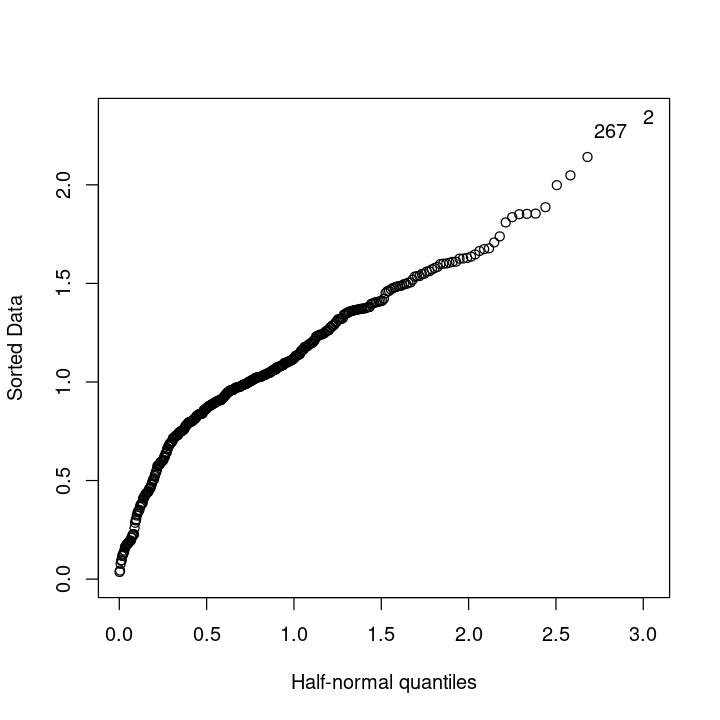

In [44]:
# Plot the residuals.  Julian Faraway's half-normal plot can
# be used to check for outliers.  See p.46 of Faraway's 
# "Extending the Linear Model with R".  The residuals plotted
# here are the deviance residuals.

options(repr.plot.width= 6, repr.plot.height= 6)

# Function halfnorm is from package faraway.
halfnorm(residuals(f03_b))


In [45]:
# Remove the 2 identified points.  Faraway's halfnorm 
# function identifies the points by their order in the
# dataframe and not by the rowname of the observation!

tmpdat <- dfb
nrow(tmpdat)
tmpdat <- tmpdat[c(-2, -267),]
nrow(tmpdat)


[1] 408

[1] 406

In [53]:
f03_b2 <- glm(Outcome ~ 
             
             I(Daysrec^1.3) + 
             I(CK^1) + 
             I(AST^-0.3),
             
            data= tmpdat, family= binomial())
summary(f03_b2)
print(get_RsqrdDev(f03_b2))



Call:
glm(formula = Outcome ~ I(Daysrec^1.3) + I(CK^1) + I(AST^-0.3), 
    family = binomial(), data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.798  -0.954  -0.315   0.979   2.360  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -1.22e+00   7.88e-01   -1.55  0.12026
I(Daysrec^1.3) -6.53e-02   4.15e-02   -1.57  0.11544
I(CK^1)        -2.11e-04   5.71e-05   -3.71  0.00021
I(AST^-0.3)     7.49e+00   3.15e+00    2.38  0.01734

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 539.92  on 405  degrees of freedom
Residual deviance: 436.59  on 402  degrees of freedom
AIC: 444.6

Number of Fisher Scoring iterations: 6


[1] 0.3055


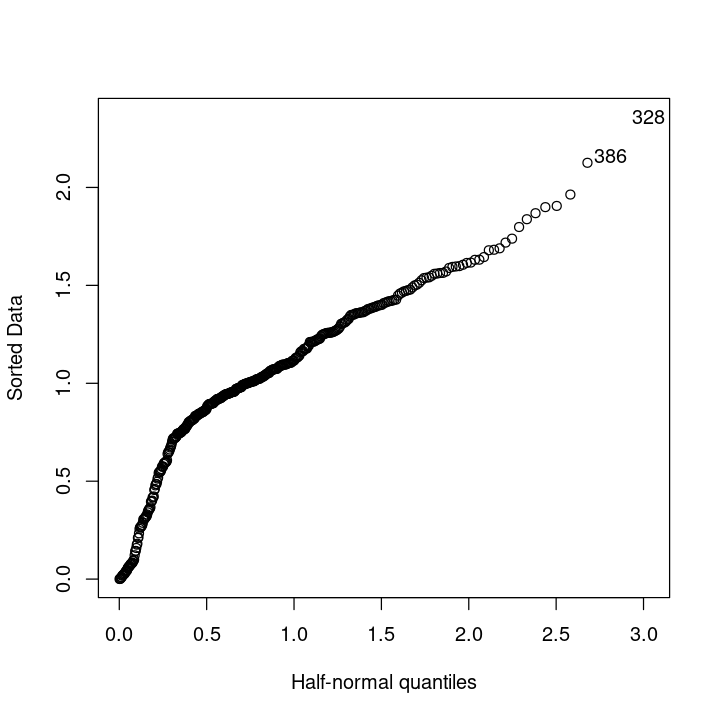

In [54]:
options(repr.plot.width= 6, repr.plot.height= 6)

halfnorm(residuals(f03_b2))


In [55]:
# Again, remove the 2 identified points.  There are
# now 404 observations remaining.

tmpdat <- tmpdat[c(-328, -386),]
nrow(tmpdat)


[1] 404

In [67]:
f03_b3 <- glm(Outcome ~ 
             
             I(Daysrec^1.3) + 
             I(CK^1) + 
             I(AST^-0.3),
             
            data= tmpdat, family= binomial())
summary(f03_b3)
print(get_RsqrdDev(f03_b3))



Call:
glm(formula = Outcome ~ I(Daysrec^1.3) + I(CK^1) + I(AST^-0.3), 
    family = binomial(), data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.817  -0.945  -0.264   0.968   2.243  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -1.184216   0.811590   -1.46  0.14453
I(Daysrec^1.3) -0.063026   0.041829   -1.51  0.13187
I(CK^1)        -0.000247   0.000064   -3.86  0.00011
I(AST^-0.3)     7.495533   3.221989    2.33  0.02000

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 536.05  on 403  degrees of freedom
Residual deviance: 425.80  on 400  degrees of freedom
AIC: 433.8

Number of Fisher Scoring iterations: 7


[1] 0.3251


In [68]:
# Tweak the power transformations.

f03_b4 <- glm(Outcome ~ 
             
             I(Daysrec^1.5) + 
             I(CK^1.25) + 
             I(AST^-0.1),
             
            data= tmpdat, family= binomial())
summary(f03_b4)
print(get_RsqrdDev(f03_b4))



Call:
glm(formula = Outcome ~ I(Daysrec^1.5) + I(CK^1.25) + I(AST^-0.1), 
    family = binomial(), data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.746  -0.959  -0.233   0.970   2.274  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -5.13e+00   2.09e+00   -2.46  0.01392
I(Daysrec^1.5) -4.16e-02   2.93e-02   -1.42  0.15546
I(CK^1.25)     -2.41e-05   6.91e-06   -3.49  0.00049
I(AST^-0.1)     9.10e+00   3.35e+00    2.71  0.00671

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 536.05  on 403  degrees of freedom
Residual deviance: 425.55  on 400  degrees of freedom
AIC: 433.6

Number of Fisher Scoring iterations: 7


[1] 0.3257


In [ ]:
### COMMENT:

# We started out with an Rsqrd of about 26%.  With the
# power transformations and the removal of 4 outliers,
# we now have a model with an Rsqrd close to 32.6%.


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
195,-1.0799,0.059290,0.012557
273,1.7705,0.038456,0.036109
344,-1.1393,0.066158,0.016244
348,2.3148,0.015148,0.047872
400,2.0827,0.013865,0.026058


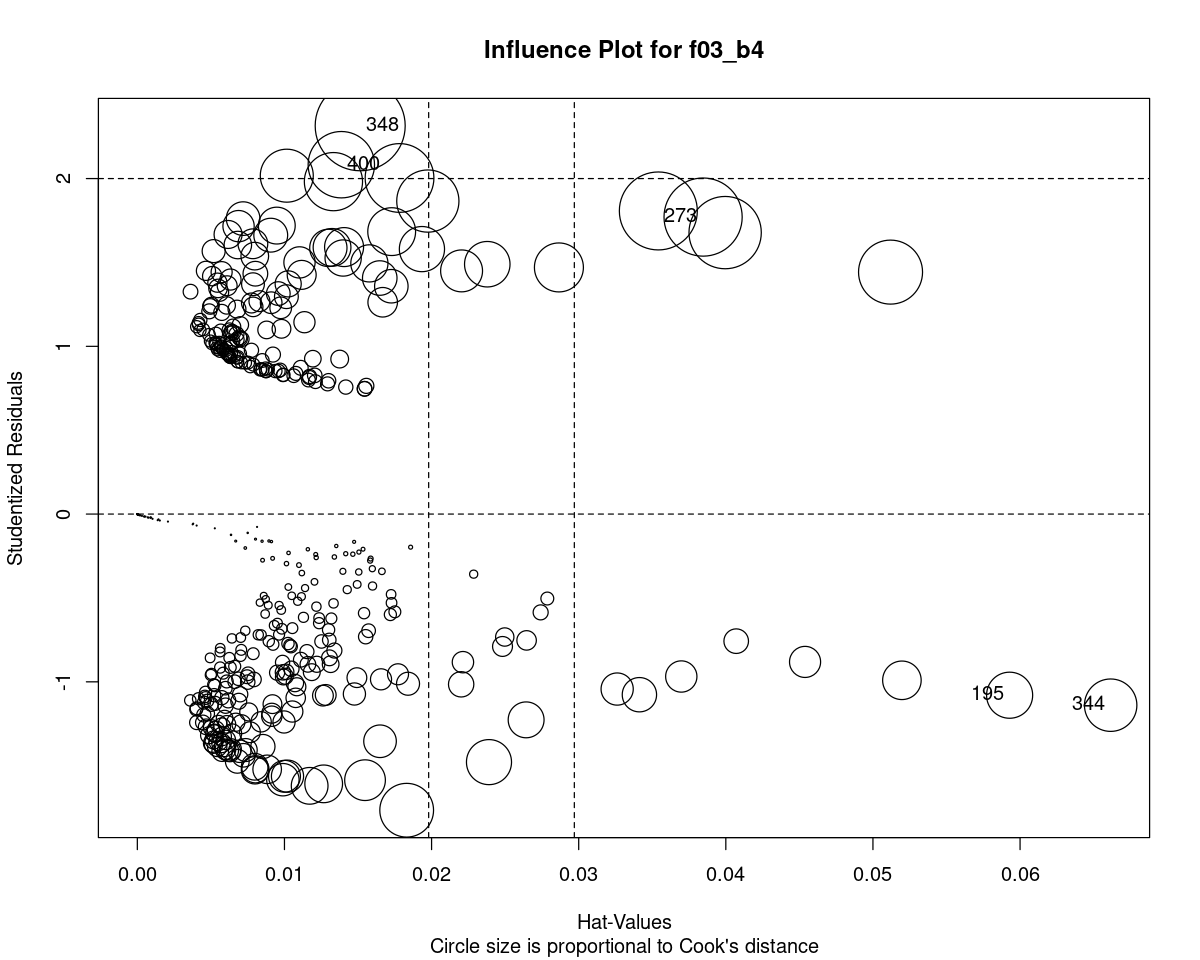

In [69]:
options(repr.plot.width= 10, repr.plot.height= 8)

# influencePlot is from the car package.
influencePlot(f03_b4, main="Influence Plot for f03_b4", 
              sub= "Circle size is proportional to Cook's distance")


In [70]:
# Remove obs. 348 from tmpdat.  Here the point is identified
# by its rowname.

tmpdat02 <- tmpdat[which(!(rownames(tmpdat) %in% c(348))),]


In [72]:
f03_b5 <- glm(Outcome ~ 
             
             I(Daysrec^1.5) + 
             I(CK^1.2) + 
             I(AST^-0.1),
             
            data= tmpdat02, family= binomial)
summary(f03_b5)
print(get_RsqrdDev(f03_b5))



Call:
glm(formula = Outcome ~ I(Daysrec^1.5) + I(CK^1.2) + I(AST^-0.1), 
    family = binomial, data = tmpdat02)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.743  -0.955  -0.207   0.963   2.127  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -4.75e+00   2.13e+00   -2.23  0.02544
I(Daysrec^1.5) -4.29e-02   2.94e-02   -1.46  0.14515
I(CK^1.2)      -4.28e-05   1.17e-05   -3.66  0.00025
I(AST^-0.1)     8.55e+00   3.41e+00    2.51  0.01220

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.23  on 399  degrees of freedom
AIC: 428.2

Number of Fisher Scoring iterations: 7


[1] 0.3352


In [74]:
# Adjust the power transformations.

f03_b6 <- glm(Outcome ~ 
             
             Daysrec + 
             I(CK^1.2) + 
             I(AST^-0.1),
             
            data= tmpdat02, family= binomial)
summary(f03_b6)
print(get_RsqrdDev(f03_b6))



Call:
glm(formula = Outcome ~ Daysrec + I(CK^1.2) + I(AST^-0.1), family = binomial, 
    data = tmpdat02)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.960  -0.208   0.959   2.139  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -4.60e+00   2.16e+00   -2.13  0.03306
Daysrec     -1.06e-01   7.10e-02   -1.50  0.13403
I(CK^1.2)   -4.25e-05   1.16e-05   -3.66  0.00025
I(AST^-0.1)  8.37e+00   3.45e+00    2.43  0.01519

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.14  on 399  degrees of freedom
AIC: 428.1

Number of Fisher Scoring iterations: 7


[1] 0.3355


In [75]:
nrow(tmpdat02)


[1] 403

In [76]:
# Update our working dataframe.

dfb <- tmpdat02


In [77]:
# Save the file.

write.csv(dfb, file="/home/greg/Documents/stat/github_repos/cows/downer.csv",
         row.names= TRUE)


In [78]:
# Re-construct the model with the dfb dataframe.

f03_b6 <- glm(Outcome ~ 
             
             Daysrec + 
             I(CK^1.2) + 
             I(AST^-0.1),
             
            data= dfb, family= binomial())
summary(f03_b6)
print(get_RsqrdDev(f03_b6))
# [1] 0.3355



Call:
glm(formula = Outcome ~ Daysrec + I(CK^1.2) + I(AST^-0.1), family = binomial(), 
    data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.960  -0.208   0.959   2.139  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -4.60e+00   2.16e+00   -2.13  0.03306
Daysrec     -1.06e-01   7.10e-02   -1.50  0.13403
I(CK^1.2)   -4.25e-05   1.16e-05   -3.66  0.00025
I(AST^-0.1)  8.37e+00   3.45e+00    2.43  0.01519

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.14  on 399  degrees of freedom
AIC: 428.1

Number of Fisher Scoring iterations: 7


[1] 0.3355


In [79]:
# If we do not lower the power transformation on CK, the
# anova on the model generates a warning message 
# (probability of 0 or 1 in glm.fit).  I find later
# that even this is not enough to prevent the anova
# function from issuing a warning.  I am not sure what
# the source of the problem is, especially given that
# no such warning is generated by glm itself.  (It may
# be that the anova function uses different default
# settings for glm.fit.)

f03_b7 <- glm(Outcome ~ 
             
             Daysrec + 
             CK + 
             I(log(AST)),
             
            data= dfb, family= binomial())
summary(f03_b7)
print(get_RsqrdDev(f03_b7))
# [1] 0.3345



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial(), 
    data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.735  -0.955  -0.240   0.961   2.118  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.862181   0.990384    2.89  0.00385
Daysrec     -0.108535   0.071057   -1.53  0.12665
CK          -0.000264   0.000069   -3.83  0.00013
I(log(AST)) -0.458373   0.209175   -2.19  0.02843

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.53  on 399  degrees of freedom
AIC: 428.5

Number of Fisher Scoring iterations: 7


[1] 0.3345


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
114,2.0255,0.017385,0.028599
232,2.0792,0.010017,0.018825
240,-1.0569,0.051118,0.010145
344,-1.1725,0.050894,0.013265
400,2.1425,0.012260,0.026451


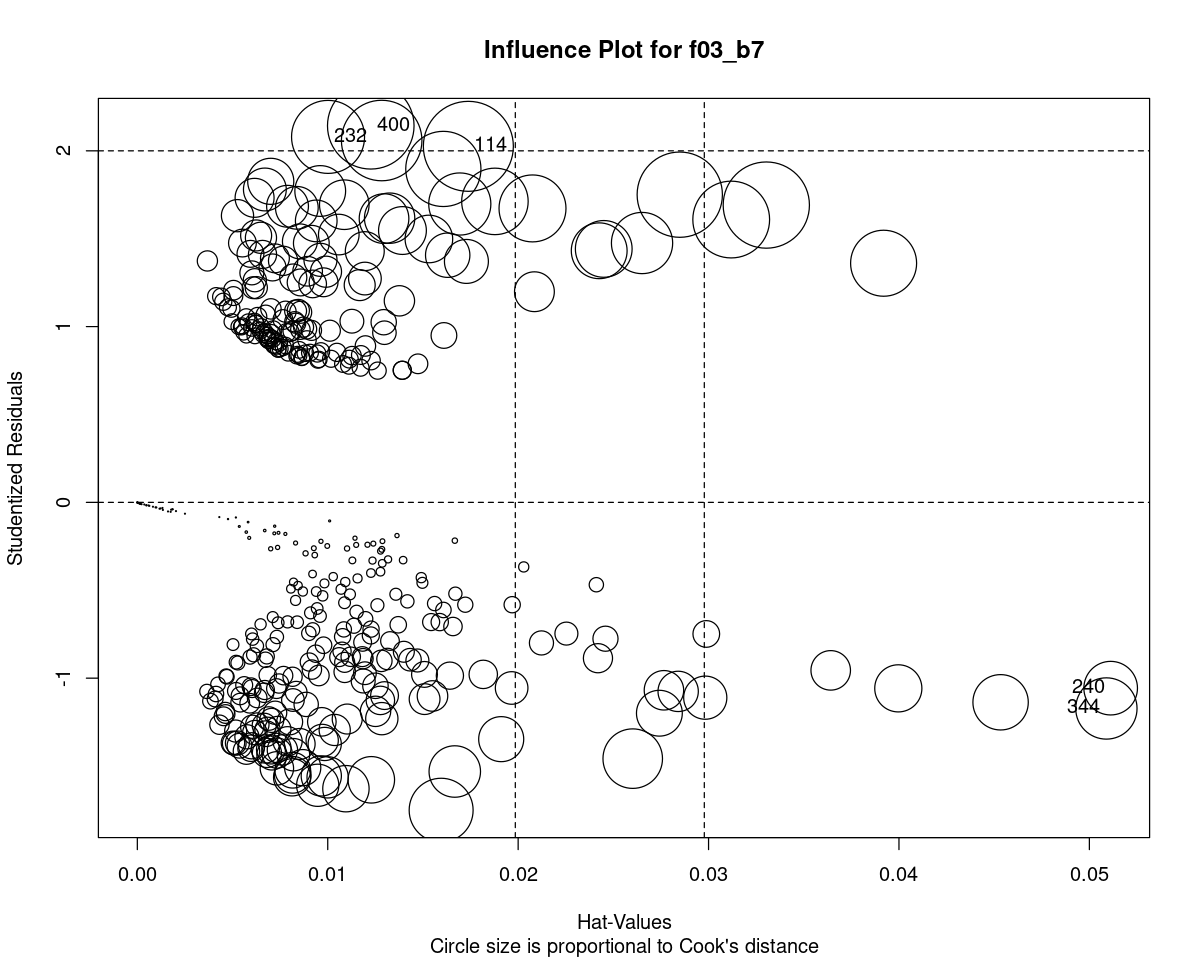

In [80]:
options(repr.plot.width= 10, repr.plot.height= 8)

influencePlot(f03_b7, main="Influence Plot for f03_b7", 
              sub= "Circle size is proportional to Cook's distance")


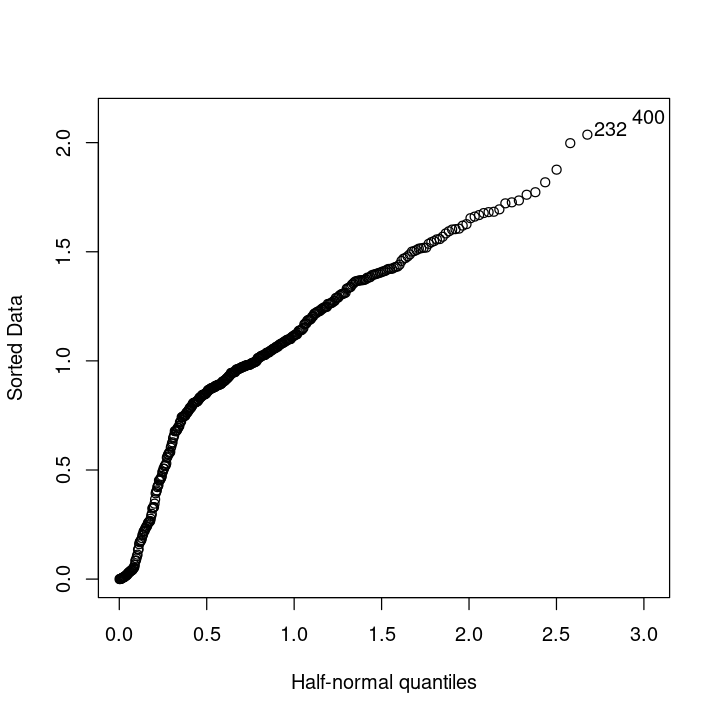

In [82]:
options(repr.plot.width= 6, repr.plot.height= 6)

halfnorm(residuals(f03_b7), labs=rownames(dfb))


In [83]:
# If we remove the last 3 influential points that are also
# outliers, our dataset will have been trimmed from 408 
# records down to 400, a reduction of nearly 2%.
# Let's see what kind of difference this makes for our
# linear model.

tmpdat <- dfb[which(!(rownames(dfb) %in% c(400, 232, 114))),]
nrow(tmpdat)


[1] 400

In [84]:
# Our Rsqrd measure increases by 2.2%.

f03_b8 <- glm(Outcome ~ 
             
             Daysrec + 
             CK + 
             I(log(AST)),
             
            data= tmpdat, family= binomial)
summary(f03_b8)
print(get_RsqrdDev(f03_b8))
# [1] 0.3565



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial, 
    data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.943  -0.186   0.943   2.160  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.89e+00   1.01e+00    2.85   0.0044
Daysrec     -1.03e-01   7.19e-02   -1.44   0.1507
CK          -3.15e-04   7.84e-05   -4.02  5.9e-05
I(log(AST)) -4.55e-01   2.15e-01   -2.11   0.0346

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 528.22  on 399  degrees of freedom
Residual deviance: 407.04  on 396  degrees of freedom
AIC: 415

Number of Fisher Scoring iterations: 7


[1] 0.3565


In [85]:
# Update our working dataframe.

dfb <- tmpdat


In [86]:
# Save the file.  dfb has 400 records in it.

write.csv(dfb, file="/home/greg/Documents/stat/github_repos/cows/downer.csv",
         row.names= TRUE)


#### Check model f03_b8 for overdispersion

In [87]:
# If the following value is close to 1, the dispersion is
# close to what our model assumes it to be.  Thus, no 
# need to correct for overdispersion.

phi <- deviance(f03_b8)/df.residual(f03_b8)
print(round(phi, 3))


[1] 1.028


In [89]:
# See p.311 of Kabacoff's "R in Action".  The null hypothesis
# is that the dispersion (phi) = 1.  The alternative hypothesis
# is that phi != 1.  If the following p-value is small (e.g.,
# < 0.05), we have good evidence for rejecting the null 
# hypothesis.

f03b8_od <- glm(Outcome ~ Daysrec + CK + I(log(AST)),  
            data= dfb, family= quasibinomial)

ans <- pchisq(summary(f03b8_od)$dispersion * f03_b8$df.residual,
              f03_b8$df.residual, lower= FALSE)
round(ans, 4)
# 0.9884  (p-value)


[1] 0.9884

### Using anova output, compute the importance of the f03 predictors

Here the importances of the predictors in the f03_b8 model are determined by their anova contributions.  Since there are 3 terms in the model and the order of the terms matters, I need to use 6 different models and average over each term's anova contribution for each model.

This section is included because I am curious to see whether the weights we arrive at for our base k-means model (with only AST, CK, and Daysrec as predictors) are at all like these anova weights.


                                     * * * * *

In [90]:
# f03_b8 is our base model.  It is built on all 400 remaining records.

f03_anova <- anova(f03_b8)
print(f03_anova)


Analysis of Deviance Table

Model: binomial, link: logit

Response: Outcome

Terms added sequentially (first to last)


            Df Deviance Resid. Df Resid. Dev
NULL                          399        528
Daysrec      1     14.0       398        514
CK           1    102.7       397        412
I(log(AST))  1      4.5       396        407


In [91]:
names(f03_anova)


[1] "Df"         "Deviance"   "Resid. Df"  "Resid. Dev"

In [136]:
rownames(f03_anova)


[1] "NULL"        "Daysrec"     "CK"          "I(log(AST))"

In [92]:
ss01 <- f03_anova$'Deviance'

names(ss01) <- c("null","Daysrec","CK","AST")
ss01tot <- sum(as.numeric(ss01[2:4]))
print(round(ss01tot, 4))


[1] 121.17


In [93]:
dayrec_percent <- round(ss01["Daysrec"]/ss01tot, 4)
ck_percent <- round(ss01["CK"]/ss01tot, 4)
ast_percent <- round(ss01["AST"]/ss01tot, 4)

ss01_contribs <- c(dayrec_percent, ck_percent, ast_percent)
print(ss01_contribs)


Daysrec      CK     AST 
 0.1152  0.8474  0.0374 


In [161]:
# Function for gauging the importance of the predictors
# in a model based on each predictor's anova contribution.
# As currently written, this function will not work if our 
# model contains interaction terms.  This function is 
# specific to the f03 series of models.

get_f03contribs <- function(dat) {
    
    # NOTE: the columns in dat must have the power
    # transformations used in the model.  The first
    # column of dat must be the model response variable.
    
    preds <- colnames(dat)[-1]
    resp <- colnames(dat)[1]
    
    # get all permutations of the predictors;
    n <- length(preds)
    perm_matrix <- gtools::permutations(n, n, preds)
    
    # create result vector for predictor contributions
    result <- rep(0, n)
    names(result) <- preds
    
    for(i in 1:nrow(perm_matrix)) {
        
        pred_str <- paste(perm_matrix[i,], collapse= "+")
        form <- as.formula(paste(as.character(resp), " ~ ", pred_str, sep=""))
        
        modl <- glm(form, family= binomial, data= dat)
        
        # The anova function calls glm.fit in a way that it sometimes
        # produces warnings: "glm.fit: fitted probabilities numerically 0 or 1 occurred"
        modl_anova <- suppressWarnings(anova(modl))
        
        ss <- modl_anova$'Deviance'
        names(ss) <- rownames(modl_anova)
        ss_total <- round(sum(as.numeric(ss[-1])), 2)
        percents <- round(ss[-1]/ss_total, 6)
        names(percents) <- names(ss)[-1]
        
        # accumulate results
        for(name in names(result)) {
            
            result[name] <- as.numeric(result[name]) + as.numeric(percents[name])
        }
        
    } # end of for-loop
    
    return(round(result/nrow(perm_matrix), 4))
}


In [139]:
# Create the dataframe for use with get_f03contribs.

tmpdat <- dfb
tmpdat$AST <- log(tmpdat$AST)
dim(tmpdat)
colnames(tmpdat)


[1] 400   4

[1] "Outcome" "Daysrec" "CK"      "AST"

In [162]:
# The following weights are obtained using all 400 records.
# These weights will be tested in Section 2 to see if they
# can improve upon the basic k-means model, i.e., one without
# weights.

ans <- get_f03contribs(tmpdat)
print(ans)
#  Daysrec      CK     AST 
#   0.0528  0.5646  0.3827

print(sum(ans))
# [1] 1.0001


Daysrec      CK     AST 
 0.0528  0.5646  0.3827 
[1] 1.0001


### Comments on anova weights

The anova weights are significantly different from the best weights for the k-means model found below.



# Section 2: Four different classification models

After models are refined, model performance measures are obtained using cross-validation scores across 5000 folds.


For model comparison I introduce what I call a "Type2" score.  This is a weighted average of the f-score (60%) and accuracy (40%).  The intent was to have a single score for model comparison.  But I find in the end that for this example dataset it is better to have, at minimum, the f-score, accuracy, and Type2 for model comparison.  In Part3 of this project, where there are 3 classification levels to work with, I stick with just the accuracy score.

## Basic Functions

In [3]:
# This function is also found in Section 1.

# Function for computing "proportion of deviance explained", an 
# R-sqrd statistic for link= logit.  See p.41 of Julian Faraway's
# "Extending the Linear Model with R" (2006: Chapman & Hall).  
# This statistic is due to N. Nagelkerke (1991; see Faraway's
# bibliography).

get_RsqrdDev <- function(modl) {
    
    n_obs <- length(modl$fitted.values)
    ans <- (1-exp((modl$deviance - modl$null.deviance)/n_obs))/(1-exp(-modl$null.deviance/n_obs))
    return(round(ans, 4))
}


In [4]:
# Function to compute f-score for a 2x2 confusion matrix.

get_fscore <- function(mat) {
    
    mat[is.na(mat)] <- 0
    FN <- as.numeric(mat[2,1])
    TP <- as.numeric(mat[2,2])
    FP <- as.numeric(mat[1,2])
    recall <- TP/(TP + FN)
    precision <- TP/(TP + FP)
    f_score <- 2* (recall*precision)/(recall + precision)
    return(round(f_score, 4))
}


In [5]:
# Function to output a confusion matrix and the f-score 
# for that matrix (if it is 2x2).

get_confusion <- function(preds, df_actual) {
    
    # df_actual is a one-column dataframe;
    # preds is a named vector of predictions;
    # preds is of type factor; it is assumed there
    # are at least 2 factor levels
    
    levs <- levels(preds)
    n_levs <- length(levs)
    if(n_levs== 1) { levs <- c('0', '1') }
    n_levs <- max(n_levs, 2)
    actual <- as.vector(df_actual[, 1])
    names(actual) <- rownames(df_actual)
    
    datout <- rep(0, n_levs * (n_levs + 1))
    dim(datout) <- c(n_levs, n_levs + 1)
    datout <- as.data.frame(datout)
    colnames(datout) <- c(levs, "class.error")
    rownames(datout) <- levs
    
    result <- vector("list", length= 2)
    names(result) <- c("matrix","f_score")
    
    # for each factor level, identify the rcd names
    # which should be classed as such
    for(rowlev in levs) {
        actlev_names <- names(actual[actual == rowlev])
        # columns are for the predicted values:
        for(collev in levs) {
            predlev_names <- names(preds[preds == collev])
            if(length(predlev_names > 0)) {
                datout[rowlev, collev] <- sum(predlev_names %in% actlev_names)
            }
        }
        nonrow_cols <- levs[!(levs %in% rowlev)]
        datout[rowlev, "class.error"] <- round(sum(as.vector(datout[rowlev, nonrow_cols]))/
                                               sum(as.vector(datout[rowlev, levs])), 4)
    }
    
    result$matrix <- datout
    if(n_levs == 2) {
        result[[2]] <- get_fscore(as.matrix(datout))
    } else {
        result$f_score <- NA
    }
    
    return(result)
}


In [6]:
# Function for identifying which cluster each record
# belongs to.

getCluster <- function(x, centers) {
    
    # x is a row of a dataframe; its columns need
    # to be in the same order as centers (a matrix
    # constructed from kmeans)
    
    cl_dist <- apply(centers, 1, function(y) sqrt(sum((x-y)^2)))
    return(which.min(cl_dist)[1])
}


In [7]:
# Function to generate combination of parameters for gridSearch;
# each combination must add to a number ~1.  Returns a dataframe, 
# each row of which is a valid combination.

# I re-factored this ftn using R's expand.grid ftn.  expand.grid
# takes more time to run.  This is probably due to type-checking. 
# It appears that we also run out of memory more quickly when
# using expand.grid.  Thus, I avoid expand.grid in what follows.

generate_combs <- function(arglist, tol=0.0001) {
    # arglist is a named list; each name is a column
    # name of the dataframe which goes to k-means
    
    #################################################
    # this next section is an alternative to expand.grid
    #################################################
    # if(FALSE) {
    n_args <- length(arglist)
  
    param_vlens <- rep(NA, n_args)
    for(i in 1:n_args) {
        param_vlens[i] <- length(arglist[[i]])
    }
    n_rows <- prod(param_vlens)
  
    datout <- rep(NA, n_args*n_rows)
    dim(datout) <- c(n_rows, n_args)
    datout <- as.data.frame(datout)
    colnames(datout) <- names(arglist)
  
    cprod <- 1
    for(j in 1:n_args) {
        vect <- arglist[[j]]
        val <- rep(vect, rep(cprod, length(vect)))
        datout[, j] <- rep(val, n_rows/length(val))
        cprod <- cprod*length(vect)
    }
        
    # } ## end of 'if(FALSE)'
    #################################################
    
    # datout <- expand.grid(arglist, KEEP.OUT.ATTRS= FALSE)
    # colnames(datout) <- names(arglist)
    
    row_sums <- round(rowSums(datout), 4)
    names(row_sums) <- rownames(datout)
    tol <- tol
    row_sums <- row_sums[which((as.numeric(row_sums) <= (1 + tol)) & (as.numeric(row_sums) >= (1 - tol)))]
    datout <- datout[names(row_sums),]
    return(datout)
}


In [8]:
# Function to constrain range of data between 0 and 1.

range01 <- function(x) {(x - min(x))/(max(x) - min(x))}


In [9]:
# Function to constrain range of data between min_x and max_x.
# This function is used to transform validation data.

range02 <- function(x, min_x, max_x) {(x - min_x)/(max_x - min_x)}


In [10]:
# Function returning mapping between clusters and
# Outcome levels.  We choose the mapping that yields
# the best accuracy score.

c1_toLevel_1 <- function(dat) {
    
    # Returns TRUE if cluster 1 maps to Outcome= 1 (survivors)
    
    # dat is a dataframe with 2 columns, c("Outcome","cluster");
    # nrow(dat) = number of predictions from the model;
    # dat$Outcome = traindat$Outcome (from the calling function)
    
    # We find the correct mapping between cluster number and 
    # Outcome level by computing accuracy scores for the different
    # valid mappings.   We choose the mapping with the best
    # accuracy score.
    
    tbl <- as.matrix(table(dat$Outcome, as.factor(dat$cluster)))
    # The colnames of tbl refer to the names of the clusters.
    
    # With only 2 levels for Outcome, we need only 2 scores.
    scores <- rep(NA, 2)    
    
    # First possibility: cluster 1 maps to non-survivors
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
        
    preds <- as.factor(tmpdat$Outcome)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    scores[1] <- ans[[2]]
    
    # Alternative mapping: cluster 1 maps to survivors
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
        
    preds <- as.factor(tmpdat$Outcome)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    scores[2] <- ans[[2]]
    
    return(scores[1] <= scores[2])
}


## Optimization functions for random forest and gradient boosting models

In [11]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from get_cvScore and is used to find the best
# parameters for the random forest and gradient boosting
# models.

get_Type2_rfgb <- function(traindat, testdat, classifier, ntrees,
                            shrinkage) {
    
    if(classifier == 'randomforest') {
        
        rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= traindat, ntree= ntrees,
                              mtry= 1, nodesize= 1)
        
        preds <- predict(rfmod, newdata= testdat, type="response")
        ans <- get_confusion(preds, testdat[, "Outcome", drop=FALSE])
    }
    
    if(classifier == 'gradientboost') {
        
        gbmod <- suppressMessages(gbm(Outcome ~ ., data= traindat, n.trees= ntrees,
                                      distribution= "bernoulli", shrinkage= shrinkage))
        
        preds <- suppressMessages(predict(gbmod, newdata= testdat, type="response"))
        preds_transf <- preds
        names(preds_transf) <- rownames(testdat)
        preds_transf[which(preds_transf >= 0.5)] <- 1
        preds_transf[which(preds_transf < 0.5)] <- 0
        preds_transf <- as.factor(preds_transf)
        ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
    }
    
    # Type2 score is a weighted average of accuracy and
    # the f-score.
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(result)
}


In [12]:
# Function to obtain a cross-validation score, averaging the
# Type2 scores of the folds.  Valid values for the classifier 
# argument are: 'randomforest' and 'gradientboost'.

get_cvScore <- function(seed, dat, classifier, ntrees,
                        folds= 5, shrinkage= 0.1) {
      
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
        
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    row_list <- vector("list", length=folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= nrow(dat))
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        valdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(valdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(valdat))) == nrow(dat))
        test_list[[j]] <- valdat
        train_list[[j]] <- traindat
    }

    # With only 5 folds, we need only 5 cores.
    scores <- mcmapply(get_Type2_rfgb, train_list, test_list,
                       MoreArgs= list(classifier= classifier, 
                                      ntrees= ntrees, shrinkage= shrinkage),
                       SIMPLIFY=TRUE, mc.cores=5)
    
    # The average is of Type2 scores.
    return(round(mean(scores), 5))
}


In [13]:
# Since the seed value has such a big effect on the results,
# I take the average over a number of seeds.

avg_seed_scores <- function(seed_vector, traindat, classifier,
                            n_trees, shrinkage= 0.01, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        if(classifier== 'randomforest') {
            outv[i] <- get_cvScore(seed, traindat, classifier, 
                                   n_trees, folds= folds)
        }
        if(classifier== 'gradientboost') {
            outv[i] <- get_cvScore(seed, traindat, classifier, n_trees, 
                                   folds=folds, shrinkage=shrinkage)
        }
    }
    
    return(round(mean(outv), 5))
}


In [14]:
# This grid search takes a vector of seeds as an argument.
# It is only for the random forest and gradient boosting 
# models.

gridSearch02 <- function(seed_vector, traindat, classifier, ntree_vector, 
                         shrinkage_vector= c(0.1), folds=5) {
    
    tree_len <- length(ntree_vector)
    shrink_len <- length(shrinkage_vector)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * shrink_len)
    dim(datout) <- c((tree_len * shrink_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        
        if(classifier== 'gradientboost') {
            for(j in 1:shrink_len) {
                index <- index + 1
                shrinkage <- shrinkage_vector[j]
                param_string <- paste(as.character(n_trees), 
                                      as.character(shrinkage), sep= "--")
                datout$params[index] <- param_string
                datout$Type2[index] <- avg_seed_scores(seed_vector, traindat, classifier, n_trees, 
                                                        folds=folds, shrinkage=shrinkage)
            }
        }
        
        if(classifier== 'randomforest') {
            index <- index + 1
            datout$params[index] <- as.character(n_trees)
            datout$Type2[index] <- avg_seed_scores(seed_vector, traindat, classifier, 
                                                    n_trees, folds= folds)
        }
    }
    return(datout)
}


## Logistic regression: final model (g03)

When observations with missing values are removed from the original 435 record dataset, we are left with 408 records.  In Section 1 above I then constructed a linear model on these 408 records and found 8 of them to be outliers (relative to my model), some of which were also influential.  These 8 records were removed from the dataset.  In this section I look at four different models constructed from the 400 remaining records.

The removal of the model-based outliers may favor the logistic regression model over the other models looked at.  That said, there is often an overlap between variable-relative outliers and model-based outliers.



In [ ]:
#&* Bookmark

In [11]:
dat <- read.csv("/home/greg/Documents/stat/github_repos/cows/downer.csv",
                    row.names= 1, header= TRUE)
dim(dat)


[1] 400   4

In [14]:
# I am satisfied with the current power transformations.

g03 <- glm(Outcome ~ Daysrec + CK + I(log(AST)),
           data= dat, family= binomial)
summary(g03)
print(get_RsqrdDev(g03))
# [1] 0.3565



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial, 
    data = dat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.943  -0.186   0.943   2.160  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.89e+00   1.01e+00    2.85   0.0044
Daysrec     -1.03e-01   7.19e-02   -1.44   0.1507
CK          -3.15e-04   7.84e-05   -4.02  5.9e-05
I(log(AST)) -4.55e-01   2.15e-01   -2.11   0.0346

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 528.22  on 399  degrees of freedom
Residual deviance: 407.04  on 396  degrees of freedom
AIC: 415

Number of Fisher Scoring iterations: 7


[1] 0.3565


In [27]:
preds <- predict(g03, newdata= dat, type="response")
preds_transf <- preds
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
table(as.factor(preds_transf))



  0   1 
253 147 

In [28]:
# The following scores are not for comparing against the other 
# models.  The value of the initial scores for each model is
# to give us a general idea of what each model can do.  

preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, dat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model g03 (400) rcds): ", as.character(ans[[2]]), sep=""))
# 0.6216

# Accuracy = 72.0%

# NOTE the even split between false positives and false negatives.

# Type2 score is 0.6610


    0  1 class.error
0 196 55      0.2191
1  57 92      0.3826


[1] ""

[1] "f-score for model g03 (400) rcds): 0.6216"


## Random forest classifier

In [29]:
# Run grid search to find parameters for the 
# random forest model.  Test with 120 seeds.

set.seed(7575)
seed_smp <- sample(1:9999, 120, replace=FALSE)
tree_vector <- c(80, 100, 120, 140, 160)

ans <- gridSearch02(seed_smp, dat, 'randomforest', tree_vector) 

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '160'

(best_rf_Type2 <- round(ans[which(ans$Type2 == max(ans$Type2)),]$Type2, 4))
# 0.6194


[1] "160"

[1] 0.6194

In [35]:
# Refine the search.  Test with 250 seeds.

set.seed(7575)
seed_smp <- sample(1:9999, 250, replace=FALSE)
tree_vector <- c(160, 200, 240, 280)

ans <- gridSearch02(seed_smp, dat, 'randomforest', tree_vector) 

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '240'

(best_rf_Type2 <- round(ans[which(ans$Type2 == max(ans$Type2)),]$Type2, 4))
# 0.6210


[1] "240"

[1] 0.621

In [36]:
# Check the degree of variation in the Type2 scores.
ans


params,Type2
<chr>,<dbl>
160,0.61885
200,0.61914
240,0.62103
280,0.61994


### Best random forest classifier: rfclf_best

In [37]:
# Output of the random forest model is dependent on
# the initial seed value.

set.seed(123)
rfclf_best <- randomForest(I(as.factor(Outcome)) ~ ., data= dat, 
                           ntree= 240, mtry= 1, nodesize= 1)
print(rfclf_best)
''
print(get_fscore(as.matrix(rfclf_best$confusion)))
# [1] 0.5833  (f-score on the training set)

# Accuracy on training set is 70.00%

# Type2 score on training set is 0.6300



Call:
 randomForest(formula = I(as.factor(Outcome)) ~ ., data = dat,      ntree = 240, mtry = 1, nodesize = 1) 
               Type of random forest: classification
                     Number of trees: 240
No. of variables tried at each split: 1

        OOB estimate of  error rate: 30%
Confusion matrix:
    0  1 class.error
0 196 55     0.21912
1  65 84     0.43624


[1] ""

[1] 0.5833


In [38]:
median(rfclf_best$err.rate[,1])


[1] 0.295

## Gradient boosting classifier

In [ ]:
# Here I use package gbm.  When I work with the 
# wine dataset in Part 3, I use xgboost.


In [41]:
# Run grid search to get parameters for the 
# gradient boosting model.  This test is with 250 seeds.

set.seed(7575)
seed_smp <- sample(1:9999, 250, replace=FALSE)
tree_vector <- c(80, 100, 120)
shrinkage_vector <- c(0.02, 0.03, 0.04) 

start <- Sys.time()
ans <- gridSearch02(seed_smp, dat, 'gradientboost', ntree_vector=tree_vector, 
                    shrinkage_vector=shrinkage_vector, folds=5) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.21 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$params)
# '100--0.03'

(best_gb_Type2 <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$Type2)
# 0.6495


Time difference of 1.21 mins

[1] "100--0.03"

[1] 0.64955

,var,rel.inf
,<chr>,<dbl>
CK,CK,61.8115
AST,AST,35.7996
Daysrec,Daysrec,2.3888


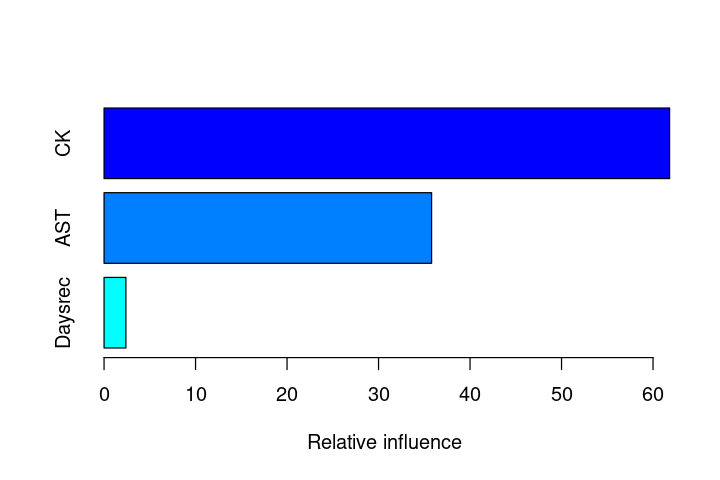

In [42]:
options(repr.plot.width= 6, repr.plot.height= 4)

# The model is seed-dependent.
set.seed(123)
gbclf_best <- gbm(Outcome ~ ., data= dat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
summary(gbclf_best)


In [43]:
# Initial model scores.

preds <- suppressMessages(predict(gbclf_best, newdata= dat, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(dat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, dat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbclf_best (400) rcds): ", as.character(ans[[2]]), sep=""))
# f-score on training set: 0.6367

# Accuracy on training set is 0.7375

# Type2 score on training set is 0.6770


    0  1 class.error
0 203 48      0.1912
1  57 92      0.3826


[1] ""

[1] "f-score for gbclf_best (400) rcds): 0.6367"


## More stable scores for rfclf_best and gbclf_best

In order to get a better sense of how the random forest and gradient boosting models perform on the 400 records, we need to average the scores for these models over many different seeds.

We see from the following results that gbclf_best performs much better than rfclf_best.

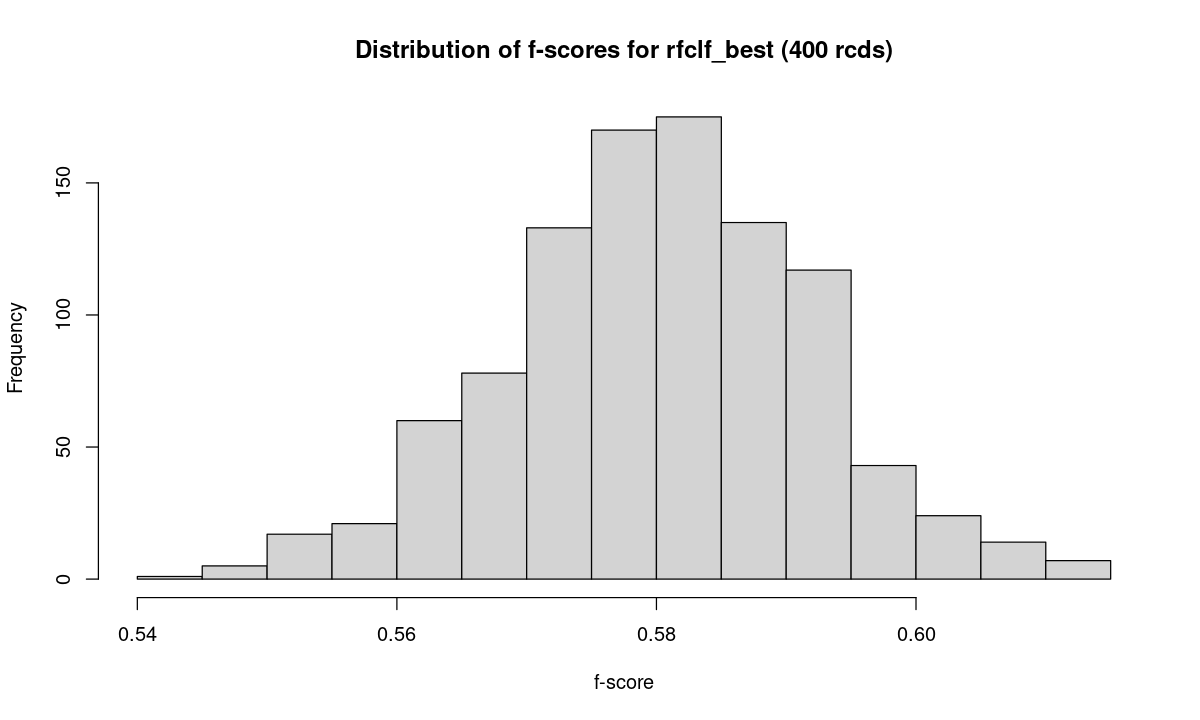

In [44]:
# Get more stable scores for the best random forest model.

set.seed(1433)
seed_smp <- sample(1:9999, 1000, replace=FALSE)

datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= dat, ntree=240,
                              mtry= 1, nodesize= 1)
        
    mat <- rfmod$confusion
    datout[i, c("Acc")] <- acc <- round(1-median(rfmod$err.rate[,1]), 4)
    datout[i, c("fscore")] <- fscore <- round(get_fscore(mat), 4)
    datout[i, c("Type2")] <- round(0.4*acc + 0.6*fscore, 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for rfclf_best (400 rcds)")


In [45]:
# Summaries for rfclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.5802   
# accuracy:  0.6932   
# false negatives: 65.43   
# false positives: 55.49

# Average Type2 score is: 0.6254


[1]  0.5802  0.6932 65.4300 55.4900

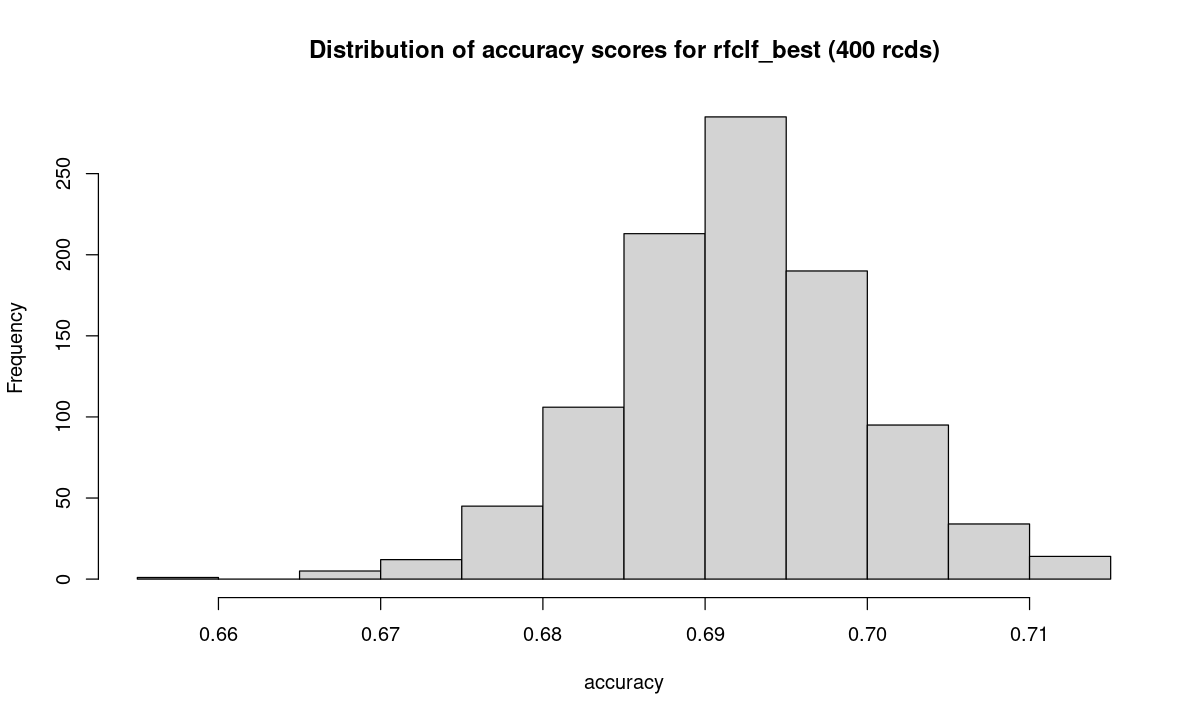

In [47]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=14, xlab="accuracy",
     main="Distribution of accuracy scores for rfclf_best (400 rcds)")


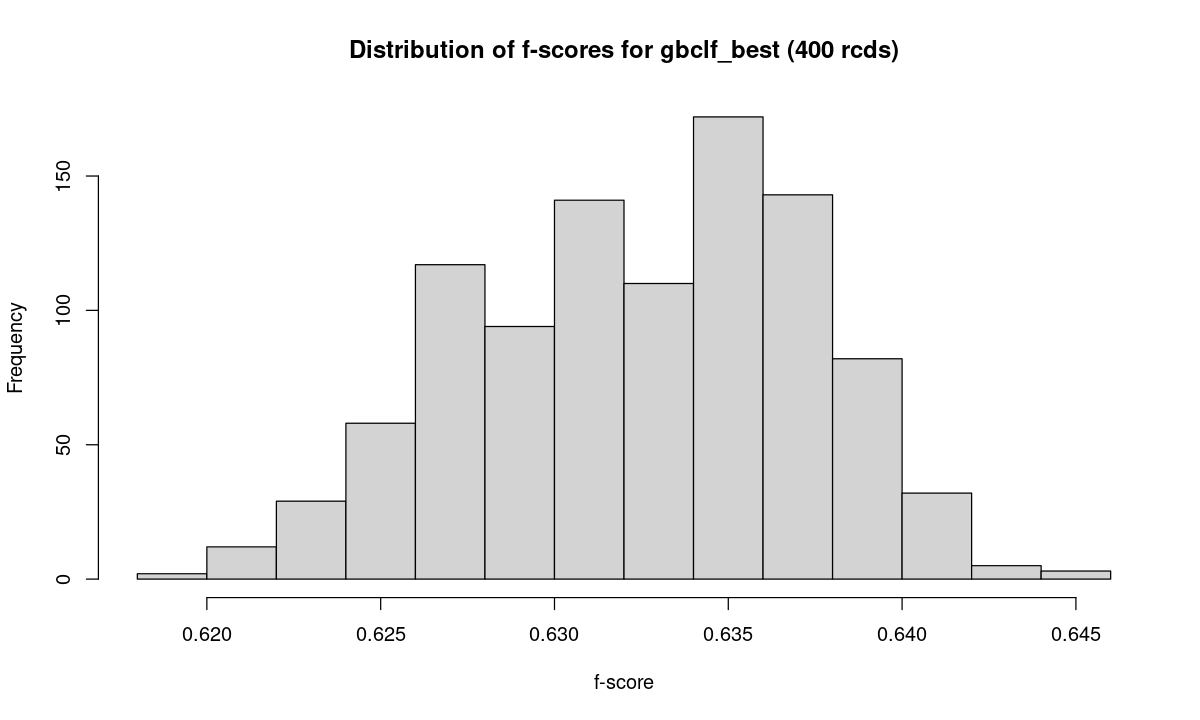

In [48]:
# Get more stable scores for the best gradient 
# boosting model.

set.seed(1433)
seed_smp <- sample(1:9999, 1000, replace=FALSE)

datout <- rep(NA, 5 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 5)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed", "fscore","Acc","FN","FP")
datout$seed <- seed_smp

for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    gbmod <- gbm(Outcome ~ ., data= dat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
        
    preds <- suppressMessages(predict(gbmod, newdata= dat, type="response"))
    preds_transf <- preds
    names(preds_transf) <- rownames(dat)
    preds_transf[which(preds_transf >= 0.5)] <- 1
    preds_transf[which(preds_transf < 0.5)] <- 0
    preds_transf <- as.factor(preds_transf)
    ans <- get_confusion(preds_transf, dat[, "Outcome", drop=FALSE])
    
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("fscore")] <- round(ans[[2]], 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for gbclf_best (400 rcds)")


In [49]:
# Summaries for gbclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.6325   
# accuracy:  0.7335   
# false negatives: 57.25   
# false positives: 49.37

# Average Type2 score is 0.6729.


[1]  0.6325  0.7335 57.2500 49.3700

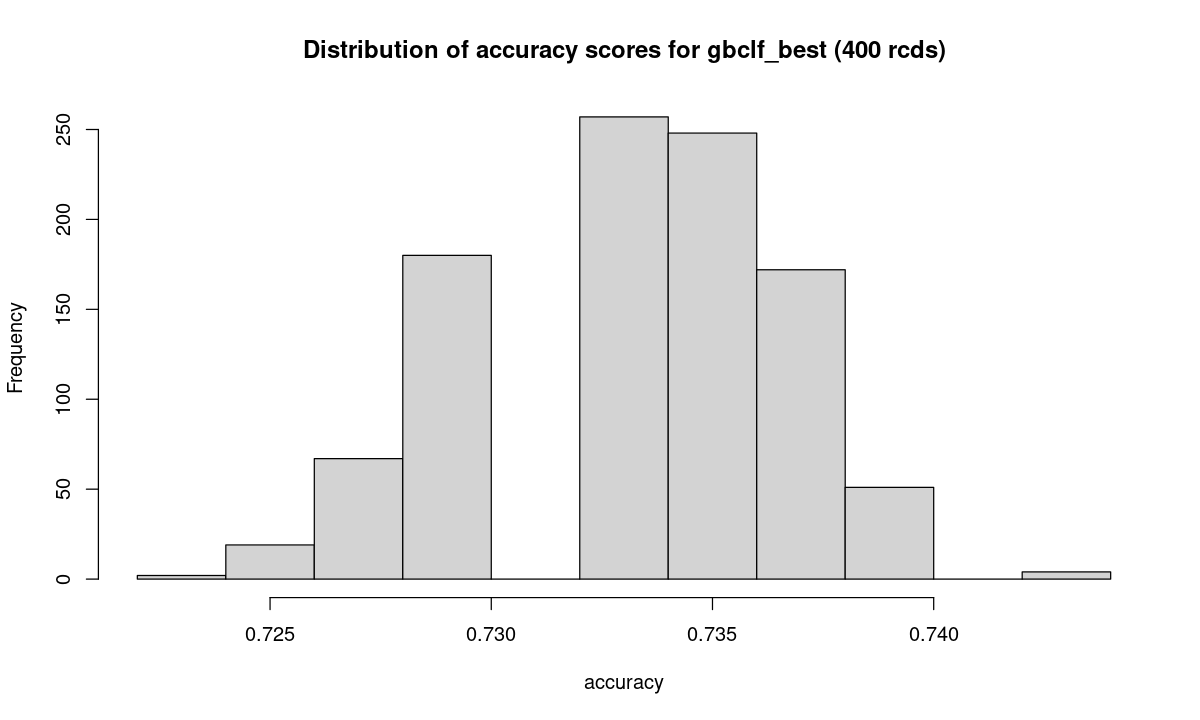

In [50]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=12, xlab="accuracy",
     main="Distribution of accuracy scores for gbclf_best (400 rcds)")


## SVM classifier

A support vector machine classifier using a radial basis function as the kernel.

In [16]:
# For SVM modeling, we need to scale the data.

# NOTE: we get a better svm model if we do not apply
# any prior transformations to the variables (such as
# taking the log or sqrt).

svmtrain <- dat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(svmtrain$Outcome, svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [17]:
svm01 <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.01, cost= 40, scale=FALSE)

pred <- fitted(svm01)
(ans <- table(pred, as.factor(svm_scaled$Outcome)))
get_fscore(as.matrix(ans))


    
pred   0   1
   0 189  53
   1  62  96

[1] 0.6254

In [35]:
# Function to compute a Type2 score for an svm cv-fold.

get_Type2_svm <- function(traindat, valdat, gamma, cost) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data= train_scaled, gamma=gamma,
                    cost=cost, scale=FALSE, kernel="radial")
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(cbind(valdat$Outcome,test_scaled), 
                                 row.names=rownames(valdat))
    colnames(test_scaled) <- colnames(valdat)
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    mat[is.na(mat)] <- 0
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * get_fscore(mat)), 4)
    return(result)
}


In [36]:
# This grid search searches for the best parameters for svm
# modeling of the data. 

gridSearch_svm <- function(seedv, dat, gammav, costv, folds=5) {
    
    gamma_len <- length(gammav)
    cost_len <- length(costv)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * gamma_len * cost_len)
    dim(datout) <- c((gamma_len * cost_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    # Divide dat by the number of folds to get a
    # size for each fold.
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    index <- 0
    for(i in 1:gamma_len) {
        gamma <- gammav[i]
        for(j in 1:cost_len) {
            index <- index + 1
            cost <- costv[j]
            param_string <- paste(as.character(gamma), 
                                  as.character(cost), sep= "--")
            datout$params[index] <- param_string
            
            # Each set of parameters gets tested over many folds.
            # The different folds are created using different seeds.
    
            # Create a vector to store the Type2 score for each seed.
            seedv_len <- length(seedv)
            seed_scores <- rep(NA, seedv_len)
    
            for(h in 1:seedv_len) {
                # shuffle dat
                cur_seed <- seedv[h]
                set.seed(cur_seed)
                smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
                dat <- dat[smp,]
    
                # Each element of row_list will be the rows we pick
                # out for one of the folds.  E.g., the first element
                # of row_list will contain the rows we want for the
                # first fold, the second element of row_list will
                # contain the rows we want for the second fold, and
                # so forth.
                row_list <- vector("list", length=folds)
                names(row_list) <- as.character(1:folds)
                startpt <- 1
                for(k in 1:folds) {
                    endpt <- startpt + segmentsv[k] - 1
                    stopifnot(endpt <= nrow(dat))
                    row_list[[k]] <- rownames(dat)[startpt:endpt]
                    startpt <- endpt + 1
                }
                
                train_list <- test_list <- vector("list", length= folds)
                for(k in 1:folds) {
                    testdat <- dat[row_list[[k]],]
                    traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                    stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                    test_list[[k]] <- testdat
                    train_list[[k]] <- traindat
                }
                
                # When there are only 5 folds, only 5 cores get used.
                scores <- mcmapply(get_Type2_svm, train_list, test_list,
                                   MoreArgs= list(gamma=gamma, cost=cost),
                                   SIMPLIFY= TRUE, mc.cores=5)
                # For the current seed, store the average of the Type2
                # scores, the average taken over the folds.
                # We need na.rm=TRUE because one or more of the scores might be NA. 
                seed_scores[h] <- round(mean(scores, na.rm=TRUE), 5)
        
            } ## end of for-loop, index h
            
            # Here I am taking an average of average scores.  This
            # could be improved by simply taking a single average.
            datout$Type2[index] <- round(mean(seed_scores), 5)
            
        } ## end of for-loop, index j
    } ## end of for-loop, index i
    
    return(datout)
}


In [20]:
# Run grid search to get better parameters for the 
# svm classifier.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.01, 0.1, by=0.01)
cost_v <- seq(20, 100, by=20)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, dat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.21 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.01--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6573


[1] "Start time: 2021-07-21 10:55:25"

Time difference of 5.21 mins

[1] "0.01--20"

[1] 0.65729

In [39]:
# Refine the search.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.004, 0.01, by=0.002)
cost_v <- seq(5, 20, by=5)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, dat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.69 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.006--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6606


[1] "Start time: 2021-07-21 20:34:51"

Time difference of 1.69 mins

[1] "0.006--20"

[1] 0.66058

In [41]:
# Construct an svm with the identified parameters.

# We need to get probability estimates from the output.
# So we set probability=TRUE.
svm02 <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.006, cost= 20, scale=FALSE, probability=TRUE)

pred <- fitted(svm02)
(ans <- table(pred, as.factor(svm_scaled$Outcome)))
print(paste("f-score for 'best' svm classifier (400 rcds): ", 
            as.character(get_fscore(as.matrix(ans))), sep=""))
# f-score: 0.6502

# Accuracy: 0.7175

# Type2 score: 0.6771


    
pred   0   1
   0 182  44
   1  69 105

[1] "f-score for 'best' svm classifier (400 rcds): 0.6502"


## Comparative cross-val scores for g03, svm02, and gbclf_best

I do not compute these scores for rfclf_best because, of the four models, it has the worst performance.  

A summary table of these scores is presented at the end of Section 4.

In [12]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the svm02 model.

get_cvScores_svm02 <- function(traindat, valdat) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data=train_scaled, kernel="radial",
                  gamma= 0.006, cost= 20, scale=FALSE, probability=TRUE)
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(test_scaled, row.names=rownames(valdat))
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    mat[is.na(mat)] <- 0
    fscore <- round(get_fscore(mat), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [41]:
# This function returns 5 cross-validation metrics for each
# seed in the seed vector, seedv.

# (This function needs to be upgraded so that it can accept a 
# function as an argument and then call that function within 
# mcmapply.)

get_cvInfo <- function(seedv, dat, folds=5) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * folds * seedv_len)
    dim(datout) <- c((seedv_len*folds), 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    # For each seed we record 5 cross-val scores
    prefixes <- rep(as.character(seedv), rep(folds, seedv_len))
    suffixes <- rep(paste(1:folds), seedv_len)
    seed_names <- paste(prefixes, suffixes, sep="--")
    rownames(datout) <- seed_names
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
    
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(k in 1:folds) {
            endpt <- startpt + segmentsv[k] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[k]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
        
        train_list <- test_list <- vector("list", length= folds)
        for(j in 1:folds) {
            testdat <- dat[row_list[[j]],]
            traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
            stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
            test_list[[j]] <- testdat
            train_list[[j]] <- traindat
        }
        # When there are only 5 folds, only 5 cores get used.
        ### NOTE: the function on the right-hand side changes depending on
        ### the model for which we want summary info.
        scores <- mcmapply(get_cvScores_kmp1_g03_v02, train_list, test_list,
                           SIMPLIFY= "array", mc.cores=5)
        
        for(k in 1:folds) {
            row_name <- paste(as.character(cur_seed), k, sep="--")
            datout[row_name, 1:5] <- scores[, k]
        }

    } ## end of for-loop, index h
    
    return(datout)
}


### svm02 comparative cross-val scores

In [56]:
# Get scores for the svm02 model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 37.62 secs


Time difference of 36.94 secs

In [57]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5614,0.6875,0.6118,9,16
4782--2,0.6441,0.7375,0.6815,16,5
4782--3,0.6667,0.6750,0.6700,16,10
4782--4,0.6667,0.7125,0.6850,15,8
4782--5,0.5806,0.6750,0.6184,18,8
9275--1,0.6462,0.7125,0.6727,14,9


In [58]:
fscore_mean <- round(mean(dat_result$fscore, na.rm=TRUE), 4)
fscore_sd <- round(sd(dat_result$fscore, na.rm=TRUE), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6320
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0628
""
summary(dat_result$fscore)


[1] "fscore mean: 0.632"

[1] "fscore StdDev: 0.0628"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.255   0.592   0.635   0.632   0.676   0.849       5 

In [59]:
Acc_mean <- round(mean(dat_result$Acc, na.rm=TRUE), 4)
Acc_sd <- round(sd(dat_result$Acc, na.rm=TRUE), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7030
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0472
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.703"

[1] "accuracy StdDev: 0.0472"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.438   0.675   0.700   0.703   0.738   0.875 

In [60]:
Type2_mean <- round(mean(dat_result$Type2, na.rm=TRUE), 4)
Type2_sd <- round(sd(dat_result$Type2, na.rm=TRUE), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6604
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0542
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6604"

[1] "Type2 StdDev: 0.0542"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.378   0.626   0.662   0.660   0.698   0.859       5 

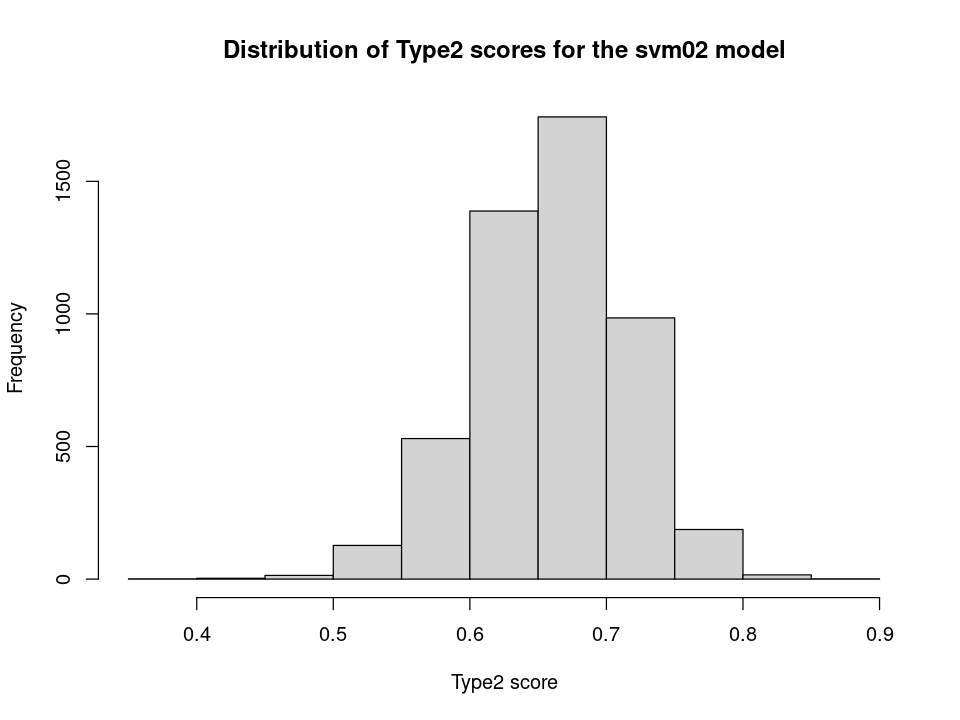

In [61]:
# Histogram of the Type2 scores for the svm02 model.

options(repr.plot.width= 8, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for the svm02 model")


In [62]:
FN_mean <- round(mean(dat_result$FN, na.rm=TRUE), 4)
FN_sd <- round(sd(dat_result$FN, na.rm=TRUE), 4)
paste0("FN mean: ", as.character(FN_mean))
# 14.53
paste0("FN StdDev: ", as.character(FN_sd))
# 3.63
""
summary(dat_result$FN)


[1] "FN mean: 14.5346"

[1] "FN StdDev: 3.6265"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    12.0    14.0    14.5    17.0    31.0 

In [63]:
FP_mean <- round(mean(dat_result$FP, na.rm=TRUE), 4)
FP_sd <- round(sd(dat_result$FP, na.rm=TRUE), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.23
paste0("FP StdDev: ", as.character(FP_sd))
# 3.16
""
summary(dat_result$FP)


[1] "FP mean: 9.229"

[1] "FP StdDev: 3.1561"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00    9.23   11.00   45.00 

### gbclf_best comparative cross-val scores

First change get_cvInfo so that it calls get_cvScores_gbclf.

In [14]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the gbclf_best model.

get_cvScores_gbclf <- function(traindat, valdat) {
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    
    preds <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    names(preds) <- rownames(valdat)
    preds <- as.factor(preds)
    
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [66]:
# Get summary scores for gbclf_best.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 35.9 secs


Time difference of 35.9 secs

In [67]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.4444,0.6250,0.5166,20,10
4782--2,0.6800,0.8000,0.7280,7,9
4782--3,0.6377,0.6875,0.6576,14,11
4782--4,0.6769,0.7375,0.7011,9,12
4782--5,0.5763,0.6875,0.6208,9,16
9275--1,0.6316,0.7375,0.6740,12,9


In [68]:
fscore_mean <- round(mean(dat_result$fscore, na.rm=TRUE), 4)
fscore_sd <- round(sd(dat_result$fscore, na.rm=TRUE), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6051
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0665
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6051"

[1] "fscore StdDev: 0.0665"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.353   0.561   0.607   0.605   0.654   0.814 

In [69]:
Acc_mean <- round(mean(dat_result$Acc, na.rm=TRUE), 4)
Acc_sd <- round(sd(dat_result$Acc, na.rm=TRUE), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7135
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0448
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7135"

[1] "accuracy StdDev: 0.0448"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.575   0.688   0.713   0.714   0.750   0.863 

In [70]:
Type2_mean <- round(mean(dat_result$Type2, na.rm=TRUE), 4)
Type2_sd <- round(sd(dat_result$Type2, na.rm=TRUE), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6485
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0552
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6485"

[1] "Type2 StdDev: 0.0552"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.447   0.612   0.648   0.648   0.686   0.833 

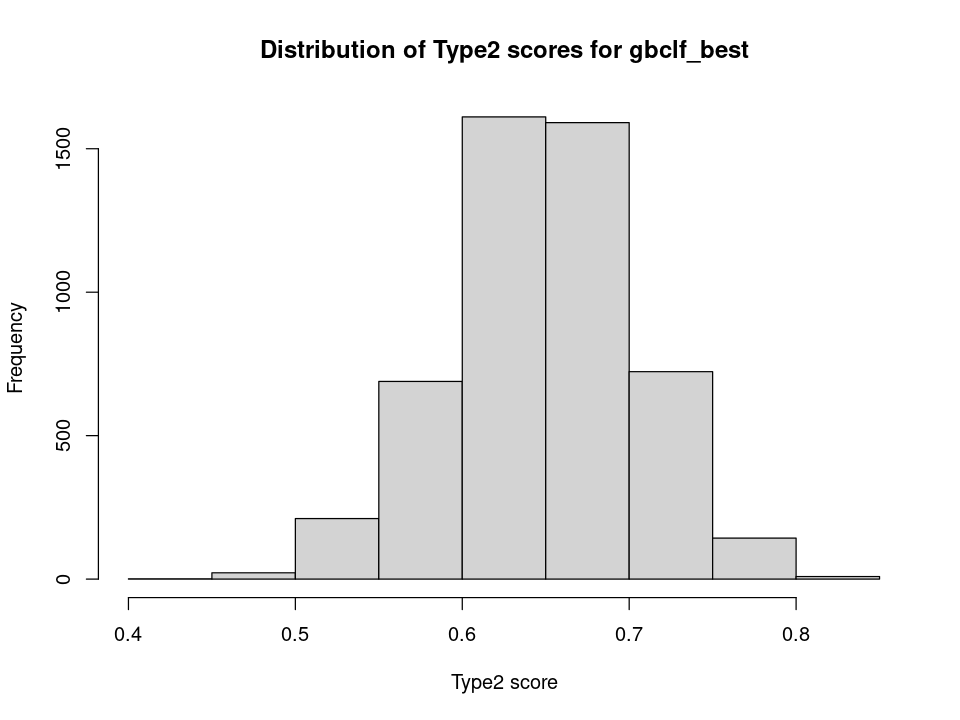

In [71]:
# Histogram of the Type2 scores for gbclf_best.

options(repr.plot.width= 8, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for gbclf_best")


In [72]:
FN_mean <- round(mean(dat_result$FN, na.rm=TRUE), 4)
FN_sd <- round(sd(dat_result$FN, na.rm=TRUE), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.03
paste0("FN StdDev: ", as.character(FN_sd))
# 3.23
""
summary(dat_result$FN)


[1] "FN mean: 12.0274"

[1] "FN StdDev: 3.2325"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2      10      12      12      14      26 

In [73]:
FP_mean <- round(mean(dat_result$FP, na.rm=TRUE), 4)
FP_sd <- round(sd(dat_result$FP, na.rm=TRUE), 4)
paste0("FP mean: ", as.character(FP_mean))
# 10.89
paste0("FP StdDev: ", as.character(FP_sd))
# 3.29
""
summary(dat_result$FP)


[1] "FP mean: 10.8928"

[1] "FP StdDev: 3.2897"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     9.0    11.0    10.9    13.0    24.0 

### g03 comparative cross-val scores

Again, first change get_cvInfo so that it calls get_cvScores_g03.

In [15]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order. 
# (First alter get_cvInfo to call this function.)

get_cvScores_g03 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    preds <- suppressWarnings(predict(g03mod, newdata= valdat, type="response"))
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    names(preds) <- rownames(valdat)
    preds <- as.factor(preds)
    
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [76]:
# Get summary scores for the g03 logistic model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 31.94 secs


Time difference of 31.94 secs

In [77]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.4615,0.6500,0.5369,20,8
4782--2,0.7170,0.8125,0.7552,5,10
4782--3,0.6667,0.7000,0.6800,12,12
4782--4,0.7077,0.7625,0.7296,8,11
4782--5,0.5763,0.6875,0.6208,9,16
9275--1,0.6207,0.7250,0.6624,12,10


In [78]:
fscore_mean <- round(mean(dat_result$fscore, na.rm=TRUE), 4)
fscore_sd <- round(sd(dat_result$fscore, na.rm=TRUE), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6183
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0646
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6183"

[1] "fscore StdDev: 0.0646"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.353   0.576   0.621   0.618   0.667   0.828 

In [79]:
Acc_mean <- round(mean(dat_result$Acc, na.rm=TRUE), 4)
Acc_sd <- round(sd(dat_result$Acc, na.rm=TRUE), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7167
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0448
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7167"

[1] "accuracy StdDev: 0.0448"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.550   0.688   0.713   0.717   0.750   0.875 

In [80]:
Type2_mean <- round(mean(dat_result$Type2, na.rm=TRUE), 4)
Type2_sd <- round(sd(dat_result$Type2, na.rm=TRUE), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6577
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0543
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6577"

[1] "Type2 StdDev: 0.0543"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.447   0.621   0.659   0.658   0.695   0.847 

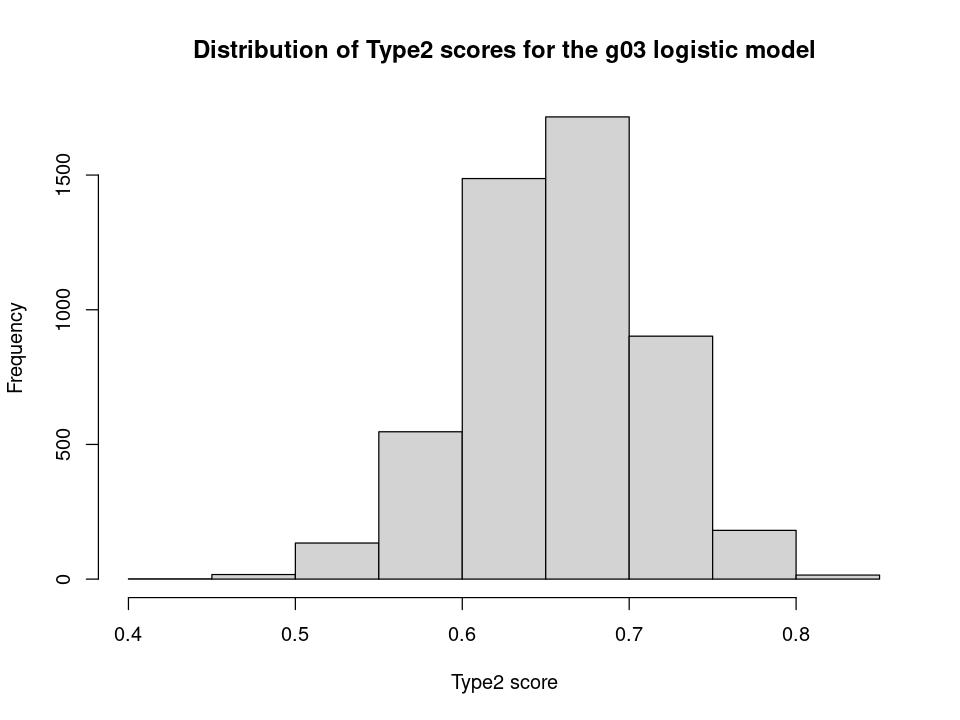

In [81]:
# Histogram of the Type2 scores for g03.

options(repr.plot.width= 8, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for the g03 logistic model")


In [82]:
FN_mean <- round(mean(dat_result$FN, na.rm=TRUE), 4)
FN_sd <- round(sd(dat_result$FN, na.rm=TRUE), 4)
paste0("FN mean: ", as.character(FN_mean))
# 11.24
paste0("FN StdDev: ", as.character(FN_sd))
# 3.04
""
summary(dat_result$FN)


[1] "FN mean: 11.2392"

[1] "FN StdDev: 3.038"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     9.0    11.0    11.2    13.0    23.0 

In [83]:
FP_mean <- round(mean(dat_result$FP, na.rm=TRUE), 4)
FP_sd <- round(sd(dat_result$FP, na.rm=TRUE), 4)
paste0("FP mean: ", as.character(FP_mean))
# 11.43
paste0("FP StdDev: ", as.character(FP_sd))
# 3.34
""
summary(dat_result$FP)


[1] "FP mean: 11.426"

[1] "FP StdDev: 3.3402"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     9.0    11.0    11.4    14.0    25.0 

## Final Comments for Section 2

svm02, g03, and gbclf_best are fairly equal in terms of performance.  svm02 has the best f-score (0.6320), whereas g03 has the best accuracy score (0.7167), edging out gbclf_best (0.7135).  A Type2 score is 60\% of the f-score plus 40\% of the accuracy.  svm02's Type2 is 0.6604; g03's Type2 is 0.6577; gbclf_best's Type2 is 0.6485.

On average, svm02 has the fewest false positives but the most false negatives.  g03 tends to have an equal number of false positives and false negatives.

A table of the above scores is found at the end of Section 4.



                                        * * * * *


# Section 3: A k-means base model

How does the k-means algorithm cluster the 400 observations for AST, CK, and Daysrec, and how well do the k-means clusters align with the levels of Outcome?

In [13]:
# Transform data for plotting.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST)
dat_plot$CK <- log(dat_plot$CK)


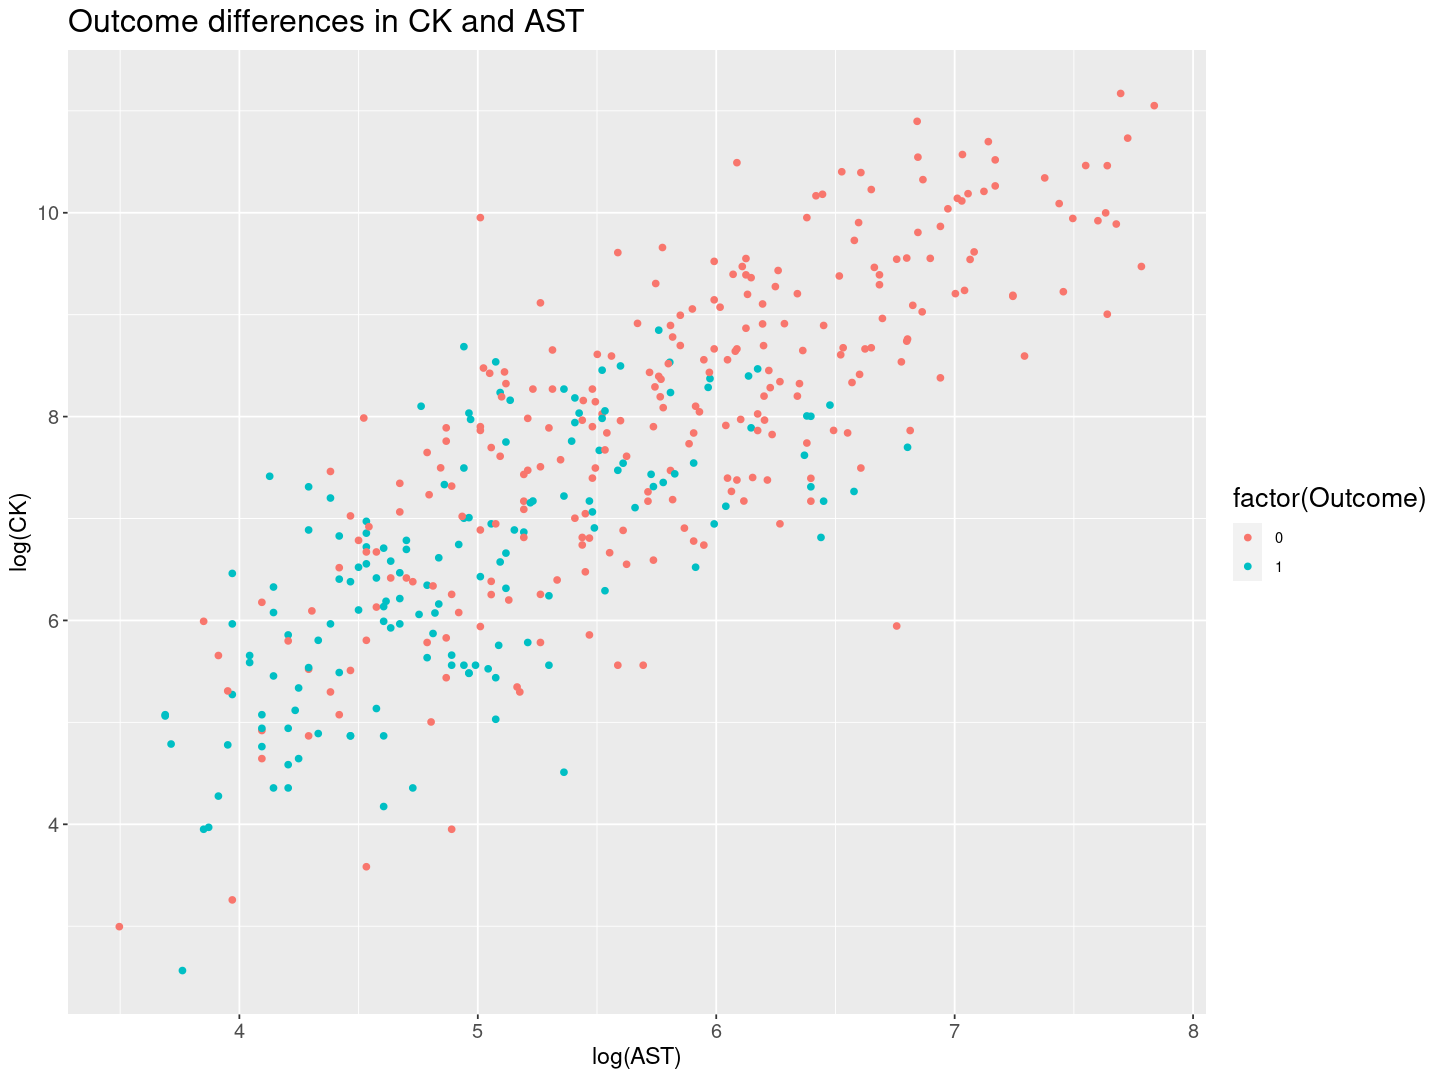

In [14]:
# Plot data to see the degree of separation between
# records with Outcome = 1 and those with Outcome = 0,
# ignoring for the moment the Daysrec dimension.

options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 1.0) +
  xlab("log(AST)") + ylab("log(CK)") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# We see in the above plot that there is a degree of 
# separation in Outcome levels based on the AST and 
# CK blood measurements.  These are the 2 most important
# dimensions we have for predicting Outcome.


In [57]:
### COMMENT:

# Can Daysrec increase the separation between levels of
# Outcome?  As this variable increases, Outcome tends to
# 0.  Also, as Daysrec increases, both CK and AST tend to
# increase.  The next plot suggests that Daysrec can help
# us distinguish between the survivors and the cows that
# did not survive.


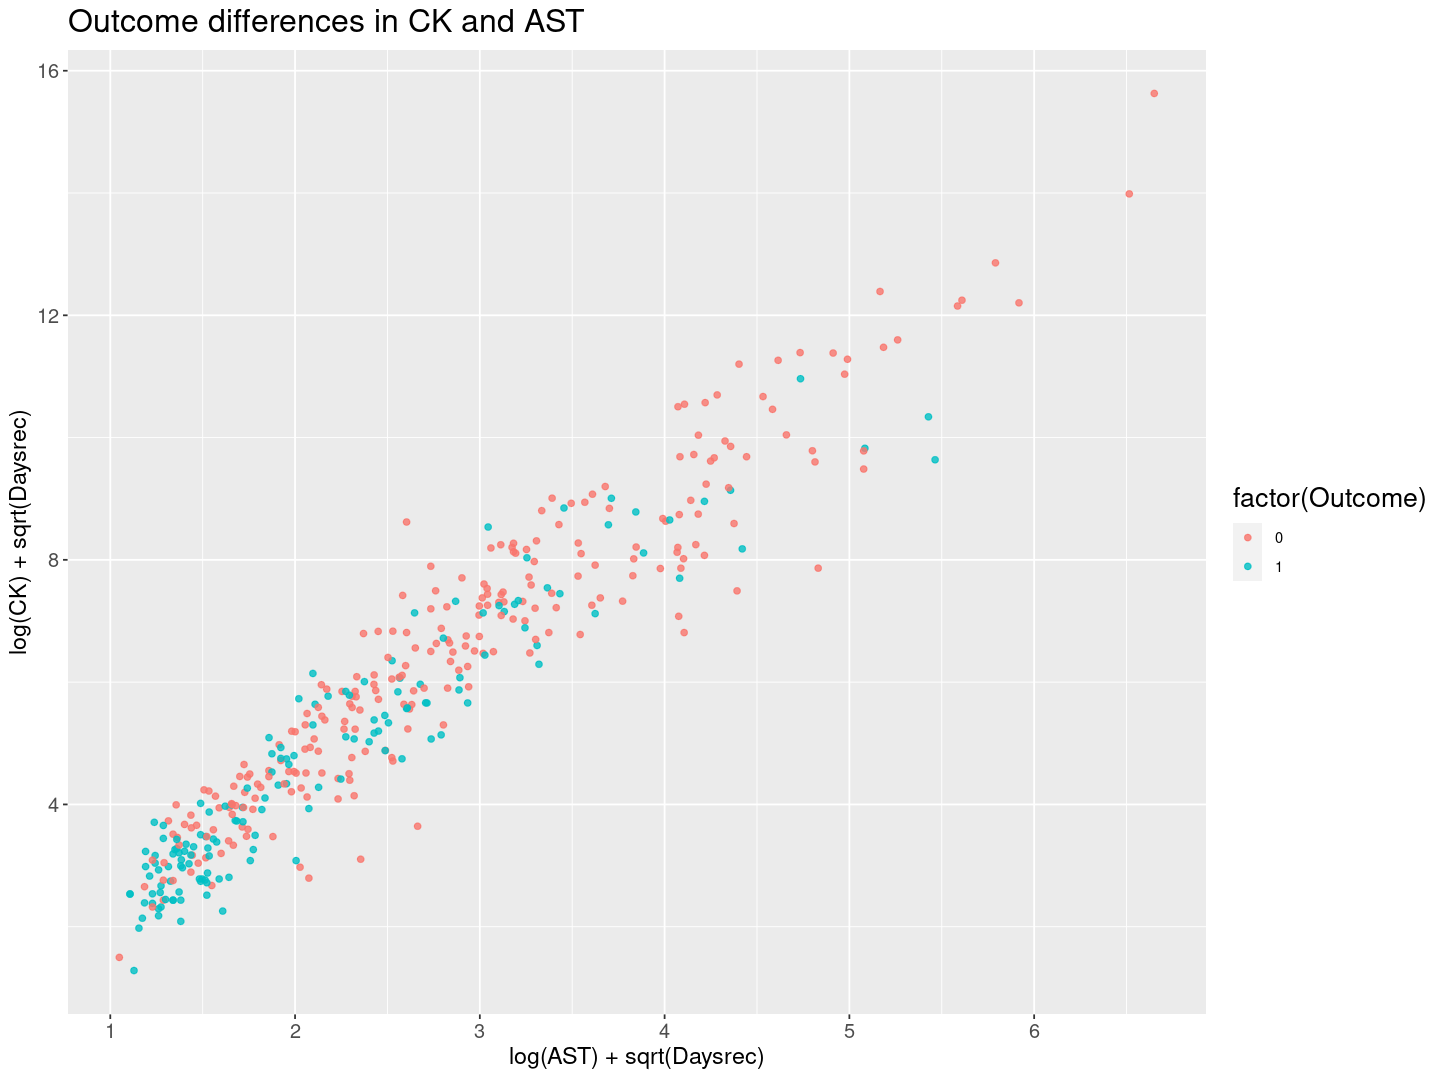

In [58]:
# Transform data for plotting.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST) * 0.3 * sqrt(1 + dat_plot$Daysrec)
dat_plot$CK <- log(dat_plot$CK) * 0.5 * sqrt(1 + dat_plot$Daysrec)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 0.8) +
  xlab("log(AST) + sqrt(Daysrec)") + ylab("log(CK) + sqrt(Daysrec)") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [59]:
# Try a different transformation.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST * 10 * sqrt(1 + dat_plot$Daysrec))  
dat_plot$CK <- (dat_plot$CK * (0.8 * sqrt(1 + dat_plot$Daysrec)))^-0.01 


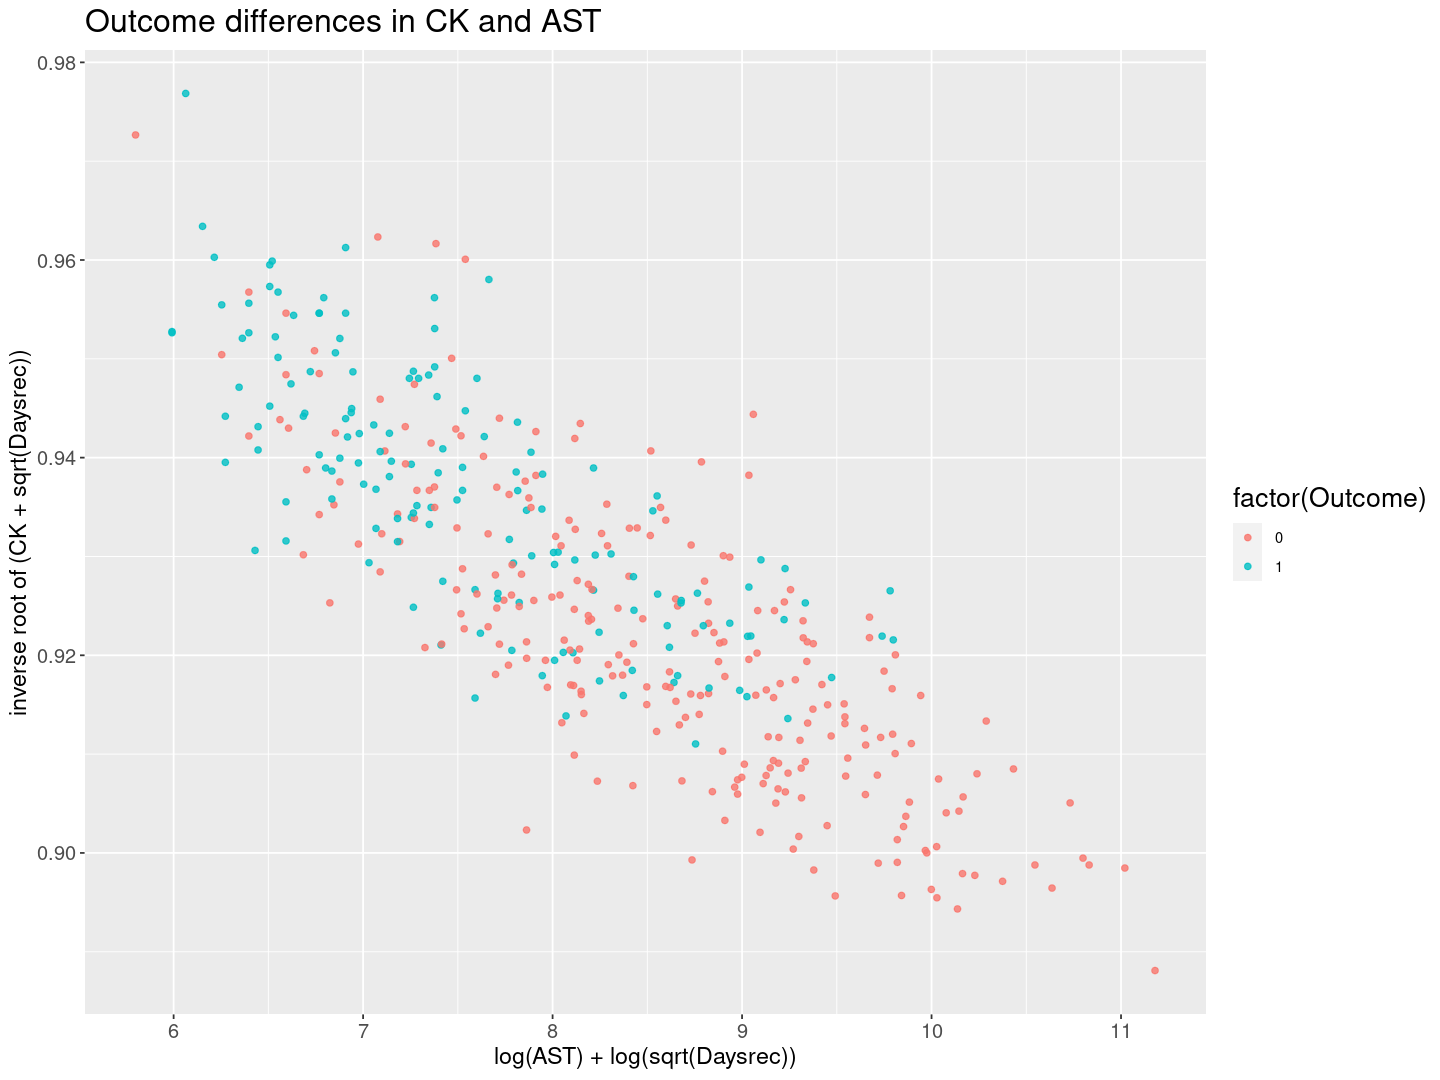

In [60]:
options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 0.8) +
  xlab("log(AST) + log(sqrt(Daysrec))") + ylab("inverse root of (CK + sqrt(Daysrec))") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


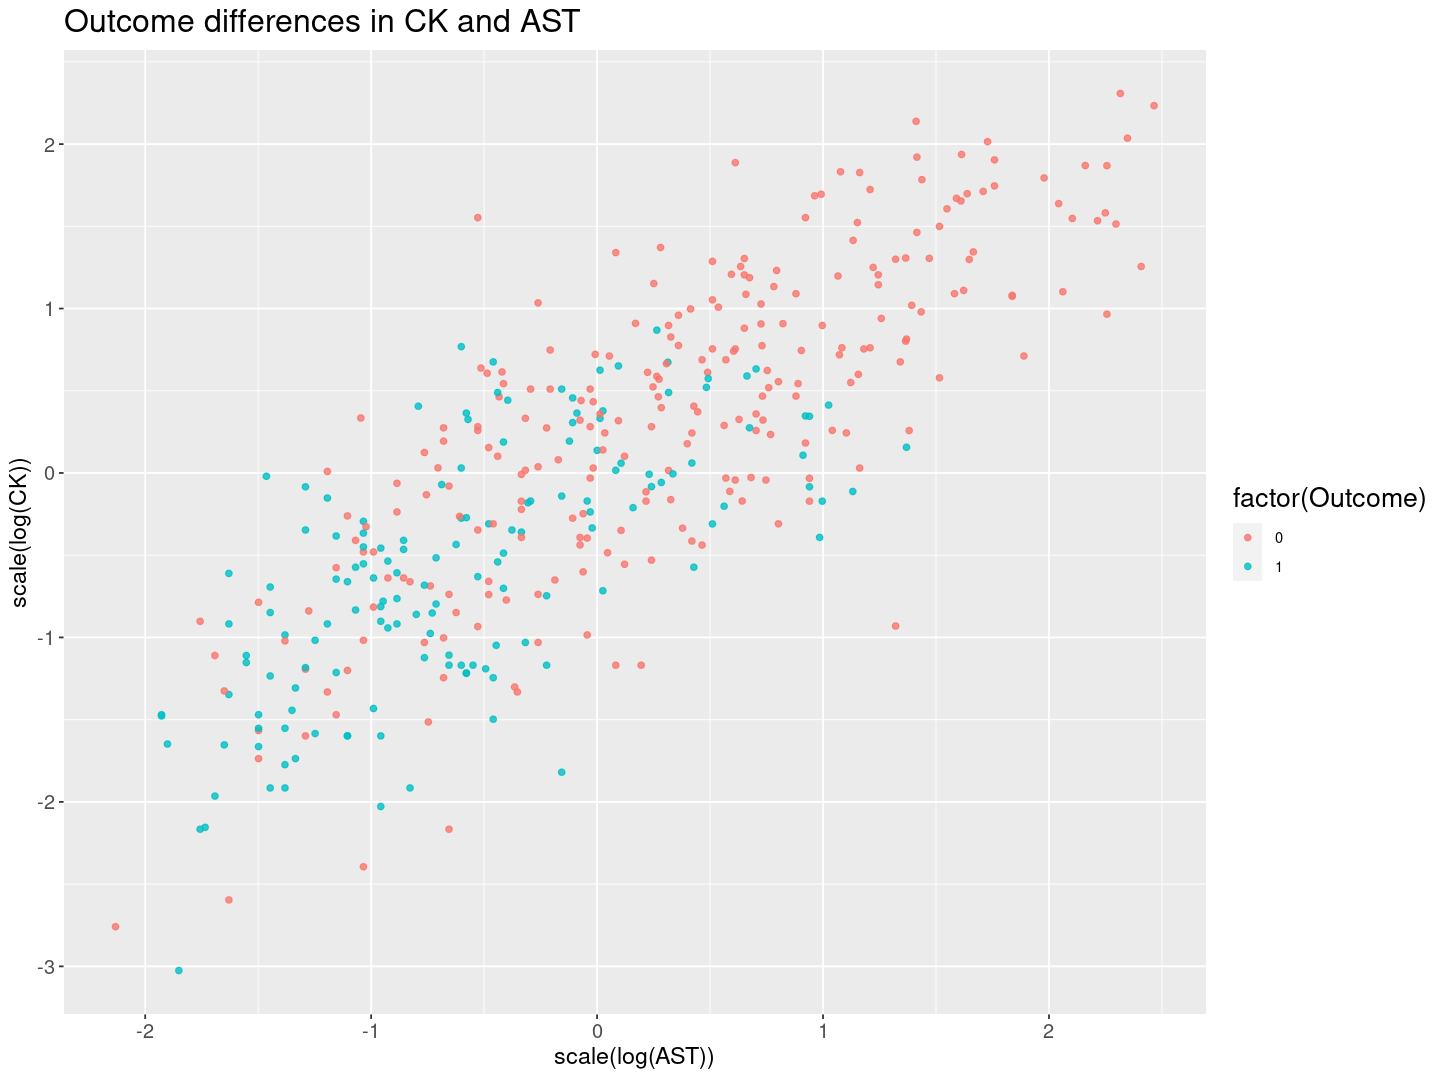

In [20]:
# Transform the data as it will be transformed
# for k-means.  HTF in "The Elements of Statistical Learning"
# point out that there are times when scaling makes it MORE
# difficult for clustering algorithms to separate the data
# as we would like, or expect.  See Figure 14.5 on p.506.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST)
dat_plot$CK <- log(dat_plot$CK)

dat_plot$AST <- scale(dat_plot$AST)
dat_plot$CK <- scale(dat_plot$CK)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 0.8) +
  xlab("scale(log(AST))") + ylab("scale(log(CK))") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


## Initial k-means model

In [12]:
# Reorder the columns of dat so that the order is
# the same as what is used for the weights.

dat <- dat[, c("Outcome","AST","CK","Daysrec")]


In [18]:
# Scale the data first.

df <- dat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
df$AST <- log(df$AST)
df$CK <- log(df$CK)
df$Daysrec <- sqrt(df$Daysrec)

df_scaled <- scale(df[, -1])
centers <- attr(df_scaled, "scaled:center")
scales <- attr(df_scaled, "scaled:scale")

df_scaled <- as.data.frame(cbind(dat$Outcome, df_scaled),
                           row.names=rownames(dat))
colnames(df_scaled) <- colnames(df)
summary(df_scaled)


    Outcome           AST                CK             Daysrec       
 Min.   :0.000   Min.   :-2.1314   Min.   :-3.0256   Min.   :-1.2537  
 1st Qu.:0.000   1st Qu.:-0.7577   1st Qu.:-0.6954   1st Qu.:-1.2537  
 Median :0.000   Median :-0.0436   Median : 0.0123   Median :-0.0179  
 Mean   :0.372   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:1.000   3rd Qu.: 0.7037   3rd Qu.: 0.6789   3rd Qu.: 0.8867  
 Max.   :1.000   Max.   : 2.4651   Max.   : 2.3078   Max.   : 2.0157  

In [19]:
# Run k-means algorithm with number of clusters set to 2.
# Remove Outcome.

set.seed(1233)
fit_km <- kmeans(df_scaled[, -1], 2, iter.max = 50, nstart = 30)
print(fit_km$size)
# [1] 216   184


[1] 183 217


In [20]:
datout <- as.data.frame(cbind(df_scaled$Outcome, fit_km$cluster))
colnames(datout) <- c("Outcome", "cluster")
rownames(datout) <- rownames(df_scaled)
head(datout)


,Outcome,cluster
,<dbl>,<dbl>
1,1,2
3,0,1
4,0,1
5,0,2
6,0,2
7,0,2


In [21]:
# max_vals identifies the Outcome level we would expect 
# each cluster to map to.

(mat <- as.matrix(table(datout$Outcome, as.factor(datout$cluster))))
max_vals <- apply(mat, MARGIN=2, which.max); print(max_vals)


   
      1   2
  0  78 173
  1 105  44

1 2 
2 1 


In [22]:
# Use function c1_toLevel_1 to get the correct 
# mapping between clusters and Outcome levels.

c1_to_Outcome1 <- c1_toLevel_1(datout)

paste("Map cluster 1 to Outcome level 1? :  ", c1_to_Outcome1, sep="")


[1] "Map cluster 1 to Outcome level 1? :  TRUE"

In [23]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
dim(tmpdat)


[1] 400   2

In [24]:
sum(rownames(tmpdat) == rownames(df_scaled)) == nrow(df_scaled)
table(as.factor(tmpdat$Outcome))


[1] TRUE


  0   1 
217 183 

In [25]:
# Get initial set of scores for the k-means model.

preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, df_scaled[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means base model (400 rcds): ", as.character(ans[[2]]), sep=""))
# f-score: 0.6325

# Accuracy: 0.6950

# Type2: 0.6575


    0   1 class.error
0 173  78      0.3108
1  44 105      0.2953


[1] ""

[1] "f-score for k-means base model (400 rcds): 0.6325"


### Comments regarding scores for k-means base model

In the next section on weights, the base model (without weights) is run against 2500 folds; the average of the Type2 scores is 0.6533.  This score beats that of our best gradient boosting model, gbclf_best (which has a comparative Type2 cross-val score of 0.6485).  The latter is supervised learning; the former is unsupervised.  

The g03 model has a comparative Type2 cross-val score of 0.6577, only 0.44 percentage points higher than the 0.6533 score.  What is notable about g03 is that, among all of the models surveyed thus far, it has the highest accuracy score (0.7167, comparative cross-val) and the second-highest f-score.

In short, the unsupervised k-means model does very well as a classifier for this dataset.  It is already competitive with our very best models.  This is a good indicator that we can use k-means to construct a better classifier than any of those we have already surveyed.  We in fact see in the next section that we only have to add weights to the model (meaning that k-means is now being used in a supervised learning setting) to have a model with a higher Type2 score than any of g03, svm02, or gbclf_best. 


## Find weights for k-means base model

Getting weights means running a grid search.  Since we want our model to apply to unseen data, the weights are established using cross-validation.  Since the parameter space is fairly large, I evaluate the weights based only on 55 "folds".  In this example, I identify the best weights as those which yield the best average Type2 score.  I use the Type2 score because it is based on accuracy, precision, and recall; it is thus a more general score than either accuracy alone or the f-score.  For this dataset I have not yet tried to find weights based on accuracy score alone.  Of course, if accuracy were the criterion by which we wanted to judge our models, then the best weights should be identified as those which yield the highest accuracy score.


Whereas the above k-means base model is unsupervised, the k-means base model with weights is constructed using supervised learning.



                                      * * * * *

In [16]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmBase <- function(traindat, valdat, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, and Daysrec.)
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat.
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [13]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation score.
# Because our training set is so small---only 400 records---we
# need to run the gridSearch over many seeds.  Otherwise, we 
# will not get a meaningful result.

gridSearch06 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "Type2")
    datout$row <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    params_rows <- rownames(df_params)
    
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are Type2 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            # stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            
            train_list <- test_list <- vector("list", length= folds)
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                # stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            ### NOTE: I change the following function call depending on
            ### the model I am scoring.
            scores <- mcmapply(get_cvScore_kmp1_g03, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the Type2
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the Type2 scores
    # obtained for each set of parameters in df_params.
    datout$Type2 <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


In [33]:
# There are 3 parameter lists to work with.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- lst[[2]] <- lst[[3]] <- seq(0.15, 0.55, by=0.01)

start <- Sys.time()
dfc01 <- generate_combs(lst, tol=0.0001)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
# 1236    3


[1] 1236    3

In [34]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]


In [35]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 18 secs (for 10 rows, 11 seeds)


Time difference of 19.91 secs

In [36]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [37]:
dfc01[best_params,]

best_Type2


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
3176,0.33,0.51,0.16


[1] 0.65657

In [38]:
# Find the best weights of those in dfc01 (1236 rows,
# 11 seeds, 5 folds).  While more seeds are better, 
# time is limited.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 41 mins


[1] "Start time: 2021-07-22 15:14:02"

Time difference of 40.81 mins

In [39]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [40]:
dfc01[best_params,]
#       	 AST 	  CK  	Daysrec 

# 25016 	0.20 	0.51	   0.29


best_Type2
# 0.6634


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
25016,0.2,0.51,0.29


[1] 0.66336

In [41]:
# Compare the above weights with no weights.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- c(0.20)
lst[[2]] <- c(0.51)
lst[[3]] <- c(0.29)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

(dfc02 <- rbind(dfc02, rep(1, 3)))


AST,CK,Daysrec
<dbl>,<dbl>,<dbl>
0.2,0.51,0.29
1.0,1.00,1.00


In [42]:
# Find the best weights of those in dfc02 (2 rows,
# 500 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 mins


[1] "Start time: 2021-07-22 15:59:27"

Time difference of 3.09 mins

In [43]:
# The weights certainly make a difference, but not as
# much of a difference for the Type2 score as I had
# expected.  The delta is only 0.008 (p-value of 
# around 1.7e-14 if we assume a standard deviation of
# 0.0538 for each distribution; the sd value is estimated
# from the comparative cross-val scores that follow).

dat_result


row,Type2
<chr>,<dbl>
1,0.66142
2,0.65326


### Compare current weights with those from a previous version of this notebook

In a previous version of this notebook the seeds used were the same, but the rows of dat started in a different order.  I ended up with a very different set of weights.  Different combinations of weights can result in very similar outcomes for the Type 2 scores.  Here I compare the previous weights with the current weights, but using 500 seeds.  (Also, the large differences in these 2 sets of weights says something about the adequacy of averaging over only 55 folds.)

In [44]:
lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- c(0.20)
lst[[2]] <- c(0.51)
lst[[3]] <- c(0.29)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dfc03 <- rbind(dfc03, c(0.59, 0.27, 0.14))


In [ ]:
set.seed(1233)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 mins


In [46]:
# The weights found in the current notebook are better,
# at least when tested over the 500 seeds.  The delta
# is 0.00094.  This delta has a p-value of 0.19, so 
# the difference we see is not statistically significant.

dat_result


row,Type2
<chr>,<dbl>
1,0.66142
2,0.66048


## Comparative cross-val scores for base k-means model with weights

In [48]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the base k-means model with weights.

get_cvScores_kmBase <- function(traindat, valdat) {
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.20, 0.51, 0.29)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names= rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat.
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [50]:
# Get scores for the base k-means model (with weights).

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.45 mins


Time difference of 3.46 mins

In [51]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5806,0.6750,0.6184,14,12
4782--2,0.7018,0.7875,0.7361,4,13
4782--3,0.6582,0.6625,0.6599,10,17
4782--4,0.6667,0.7000,0.6800,7,17
4782--5,0.5806,0.6750,0.6184,8,18
9275--1,0.6667,0.7375,0.6950,9,12


In [52]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6348
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0620
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6348"

[1] "fscore StdDev: 0.062"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.385   0.594   0.636   0.635   0.677   0.824 

In [53]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7004
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0462
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7004"

[1] "accuracy StdDev: 0.0462"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.525   0.675   0.700   0.700   0.738   0.863 

In [54]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6610
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0532
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.661"

[1] "Type2 StdDev: 0.0532"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.460   0.626   0.662   0.661   0.696   0.837 

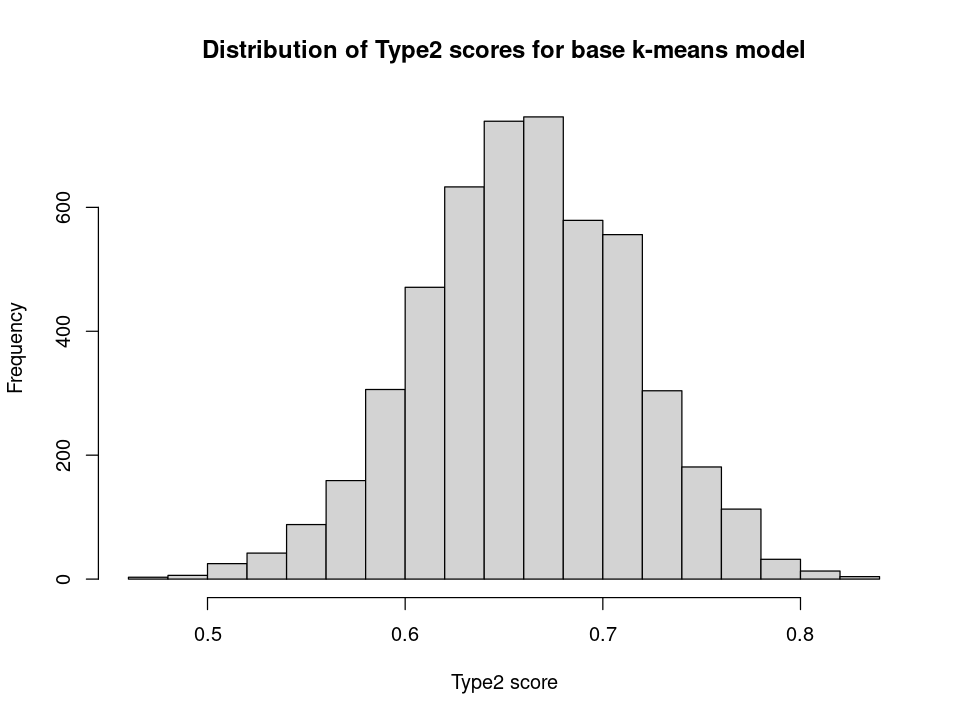

In [56]:
# Histogram of the Type2 scores for the base k-means model.

options(repr.plot.width= 8, repr.plot.height= 6)
hist(dat_result$Type2, breaks=14, xlab="Type2 score",
     main="Distribution of Type2 scores for base k-means model")


In [57]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 8.72
paste0("FN StdDev: ", as.character(FN_sd))
# 2.46
""
summary(dat_result$FN)


[1] "FN mean: 8.7152"

[1] "FN StdDev: 2.4557"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    7.00    9.00    8.72   10.00   18.00 

In [58]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 15.25
paste0("FP StdDev: ", as.character(FP_sd))
# 3.14
""
summary(dat_result$FP)


[1] "FP mean: 15.2548"

[1] "FP StdDev: 3.1381"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    13.0    15.0    15.3    17.0    27.0 

## Final comments for Section 3

When weights are added to the k-means base model, we obtain a Type2 score (0.6610) that is greater than that of any of the previous models.  svm02 has the next largest comparative Type2 cross-val score: 0.6604.  (The p-value for the hypothesis that 0.6610 > 0.6604 is 0.29.  So the difference here is not statistically significant.)  

The k-means model with weights has an f-score of 0.6348.  svm02 has the next largest f-score: 0.6320.  (The p-value for the hypothesis that 0.6348 > 0.6320 is 0.0124.)  In terms of the f-score, then, the k-means model with weights does better than the other three models.  Its average number of false negatives is the lowest; but its average number of false positives is the highest.

The k-means model with weights has an accuracy score of 0.7004.  This score is lower than those for g03, gbclf_best, and svm02.  svm02 has the next lowest accuracy score of 0.7030.

Overall, the k-means model with weights has a performance on par with those of our other three models: g03, gbclf_best, and svm02.

In Section 4 I construct a hybrid k-means model which out-performs all of the models that we have reviewed thus far.


# Section 4: k-means hybrid model

Add a predicted Outcome column (called "prob01") to the dataframe that k-means is applied to.  See if this additional column improves the clustering solution.  This approach further leverages supervised learning to improve upon, or boost, the unsupervised k-means algorithm.  It would seem that in order for the prob01 column to boost the performance of the k-means model, it will need to not only (a) bring in new information; but also (b) add to, rather than subtract from the information already found in the other variables.  In other words, the new information will need to complement, rather than conflict with, that found in the other variables. 


Even though g03, svm02, and gbclf_best are nearly equal as classifiers, the differences between them are such that it matters greatly which model we rely on  to create a hybrid k-means model.  In previous work I had first chosen svm02 because it has the highest Type2 score; but this choice weakened the performance of the hybrid model.  I then created a hybrid model with both svm02 and gbclf_best informing the k-means algorithm.  This led to an even worse performance.  Next I chose the model (in this case, g03) with the best accuracy score rather than the best Type2 score.  This approach produced a better model.  The approach is presented in what follows.



                                    * * * * *

In [14]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06; it helps us find the best
# set of weights for the hybrid model whose prob01 column
# is formed from g03 output.

get_cvScore_kmp1_g03 <- function(traindat, valdat, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- predict(g03mod, newdata=valdat)
    valdat$prob01 <- as.numeric(preds01_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [15]:
# There are 4 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.25.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [ ]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 19 secs (for 10 rows, 10 seeds)


In [ ]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc01[best_params,]

best_Type2


In [20]:
# Find the best weights of those in dfc01 (1469 rows,
# 15 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 15, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.27 hours


[1] "Start time: 2021-07-23 10:18:29"

Time difference of 1.27 hours

In [21]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [22]:
dfc01[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 16213 	0.15 	0.37	   0.21 	  0.27


best_Type2
# 0.6649


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
16213,0.15,0.37,0.21,0.27


[1] 0.66489

In [27]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.09, 0.15, by= 0.02)
lst[[2]] <- seq(0.37, 0.45, by= 0.01)
lst[[3]] <- seq(0.11, 0.23, by= 0.02)
lst[[4]] <- seq(0.25, 0.35, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  209     4


[1] 172   4

In [28]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.

dfc02 <- rbind(dfc02, rep(1,4))


In [29]:
dat_result_dfc01 <- dat_result


In [30]:
# Find the best weights of those in dfc02 (173 rows,
# 15 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 15, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 9.48 mins


[1] "Start time: 2021-07-23 12:45:58"

Time difference of 9.48 mins

In [31]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [32]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 660   	0.15 	0.39	   0.19 	  0.27

best_Type2
# 0.6655


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
660,0.15,0.39,0.19,0.27


[1] 0.66546

In [33]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.13, 0.17, by= 0.01)
lst[[2]] <- seq(0.37, 0.43, by= 0.01)
lst[[3]] <- seq(0.15, 0.21, by= 0.01)
lst[[4]] <- seq(0.25, 0.31, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  92     4


[1] 170   4

In [34]:
dat_result_dfc02 <- dat_result


In [35]:
# Find the best weights of those in dfc02 (170 rows,
# 15 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 15, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 9 mins


[1] "Start time: 2021-07-23 13:01:03"

Time difference of 9.06 mins

In [36]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [37]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 647    	0.14 	0.40	   0.19 	  0.27

best_Type2
# 0.6655


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
647,0.14,0.4,0.19,0.27


[1] 0.66551

## Summary info for hybrid model with prob01 constructed from g03

First change get_cvInfo to call the function in the next cell.

In [45]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column.

get_cvScores_kmp1_g03 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    #############################
    # Transform and scale training set data.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  
    
    wghts <- c(0.14, 0.40, 0.19, 0.27)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- predict(g03mod, newdata=valdat)
    valdat$prob01 <- as.numeric(preds01_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [46]:
# Get scores for the hybrid model with prob01 constructed 
# from the g03 logistic model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.53 mins


Time difference of 3.4 mins

In [47]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.4800,0.6750,0.5580,20,6
4782--2,0.6531,0.7875,0.7069,8,9
4782--3,0.6571,0.7000,0.6743,13,11
4782--4,0.6667,0.7375,0.6950,10,11
4782--5,0.6182,0.7375,0.6659,9,12
9275--1,0.6296,0.7500,0.6778,13,7


In [48]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6163
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0676
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6163"

[1] "fscore StdDev: 0.0676"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.323   0.571   0.618   0.616   0.667   0.842 

In [49]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7298
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0443
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7298"

[1] "accuracy StdDev: 0.0443"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.575   0.700   0.725   0.730   0.762   0.887 

In [50]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6617
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0556
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6617"

[1] "Type2 StdDev: 0.0556"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.456   0.625   0.662   0.662   0.700   0.860 

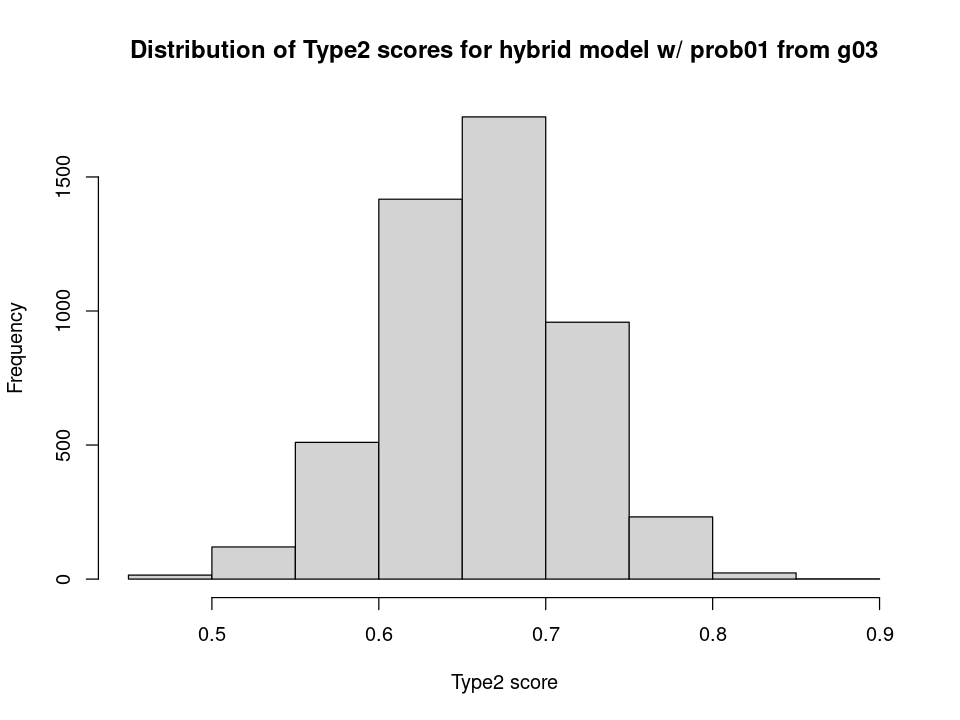

In [51]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 8, repr.plot.height= 6)
hist(dat_result$Type2, breaks=14, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ prob01 from g03")


In [52]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.22
paste0("FN StdDev: ", as.character(FN_sd))
# 3.06
""
summary(dat_result$FN)


[1] "FN mean: 12.2196"

[1] "FN StdDev: 3.0643"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    10.0    12.0    12.2    14.0    23.0 

In [53]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.40
paste0("FP StdDev: ", as.character(FP_sd))
# 3.00
""
summary(dat_result$FP)


[1] "FP mean: 9.3952"

[1] "FP StdDev: 3.0007"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     7.0     9.0     9.4    11.0    21.0 

## Summary table for Section 4 results

In [54]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part1_Sect4.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  5 10

In [ ]:
#&* Bookmark

In [55]:
# The following table is a summary of all the 
# results from Sections 3 and 4.  Recall that
# the Type2 score is 60% f-score and 40% accuracy.

results


,fscore,fscore_sd,accuracy,acc_sd,Type2,Type2_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g03,0.6183,0.0646,0.7167,0.0448,0.6577,0.0543,11.24,3.04,11.43,3.34
gbclf,0.6051,0.0665,0.7135,0.0448,0.6485,0.0552,12.03,3.23,10.89,3.29
svm02,0.6320,0.0628,0.7030,0.0472,0.6604,0.0542,14.53,3.63,9.23,3.16
km_wghts,0.6348,0.0620,0.7004,0.0462,0.6610,0.0532,8.72,2.46,15.25,3.14
kmp1_g03,0.6163,0.0676,0.7298,0.0443,0.6617,0.0556,12.22,3.06,9.40,3.00


## Final Comments for Section 4

Of the entries in the above table, the hybrid k-means model has the best accuracy score (0.7298) and the best Type2 score (0.6617). The next best non-k-means Type2 score is for svm02 (0.6604).  The p-value for the hypothesis 0.6617 > 0.6604 is 0.12, so the difference we see is not statistically significant.  However, the hybrid model is clearly a better model than svm02 because it has a much higher accuracy score (p-value for the delta is < 2e-16); on average, the hybrid model has significantly fewer false negatives than svm02 and nearly the same average number of false positives.

The hybrid model also outperforms g03, the model with the next highest accuracy score (p-value for the delta is < 2e-16).  On average, the hybrid model has significantly fewer false positives than g03.

The 2 k-means models in the table are about equal in overall performance.  The hybrid model has significantly fewer false positives, but significantly more false negatives.  The hybrid model has a significantly lower f-score, but it makes up for this with its significantly higher accuracy score.  If the k-means algorithm was less suited to the cow data, km_wghts would not be nearly so equal in performance to kmp1_g03.



                                      * * * * *
                                      
We can try to further boost the above hybrid model by adding a second probability column (prob02).  In order to see a boost in performance, the additional column will need to contain new information that complements what is already there in the other columns.  If we generate prob02 using gbclf_best, the new hybrid model (at least in the testing I have done) did not perform any better than kmp1_g03.



                                      * * * * * 


The work in this notebook shows that k-means can be used to boost the performance of models.  Under the right conditions, it can yield the best-performing model among those surveyed.  The choices made in the construction of the hybrid model matter a lot: we need to choose the "right" model for constructing the prob01 column in order to get a model better than the competing models, keeping in mind that there is no guarantee that the hybrid model will always perform better than all competing models.  But this is true about any modeling approach; there is no single algorithm or approach that will always provide us with the best predictive model.  

In Part2 and Part3 I apply the approach to two other datasets.  We will then have 3 examples on 3 very different datasets that we can use to gauge the potential for k-means to boost the performance of other classifiers.



# Addendum: More plots showing separation of points by Outcome level

In [12]:
newtrain <- dat

g03 <- glm(Outcome ~ Daysrec + CK + I(log(AST)),
           data= dat, family= binomial)
    
preds <- preds <- predict(g03, newdata= dat, type="response")
newtrain$prob01 <- preds


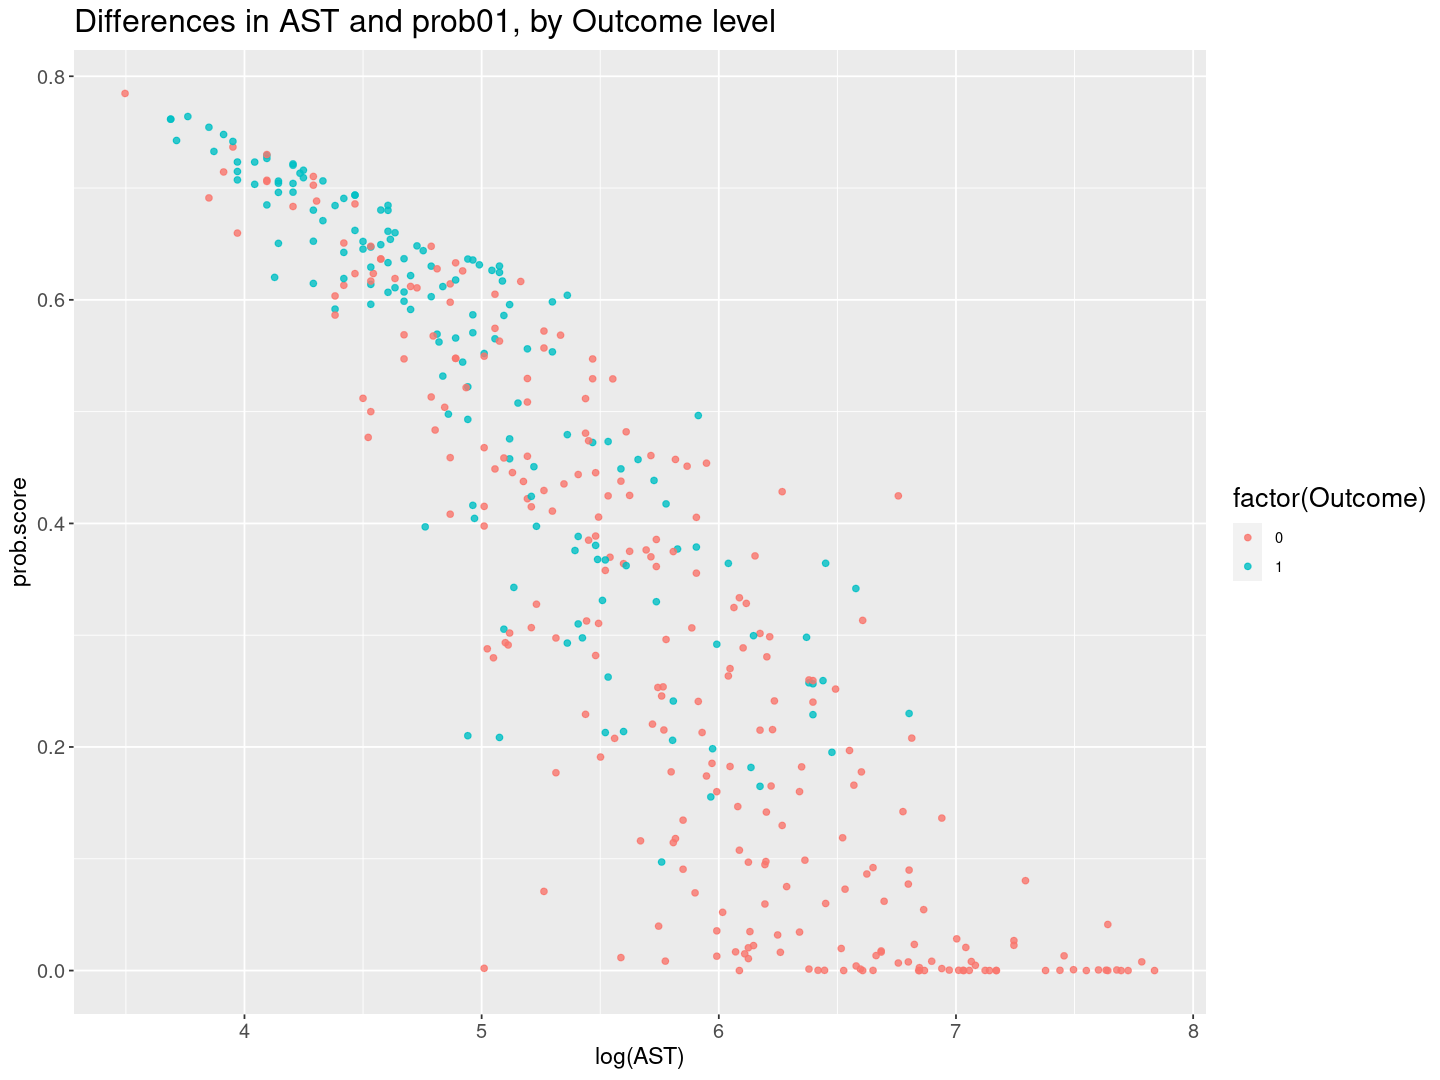

In [13]:
dat_plot <- newtrain[, c("Outcome","AST","prob01"), drop=FALSE]
dat_plot$AST <- log(dat_plot$AST)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, prob01, color= factor(Outcome))) +

  geom_point(alpha= 0.8) + 
  xlab("log(AST)") + ylab("prob.score") +
  ggtitle("Differences in AST and prob01, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


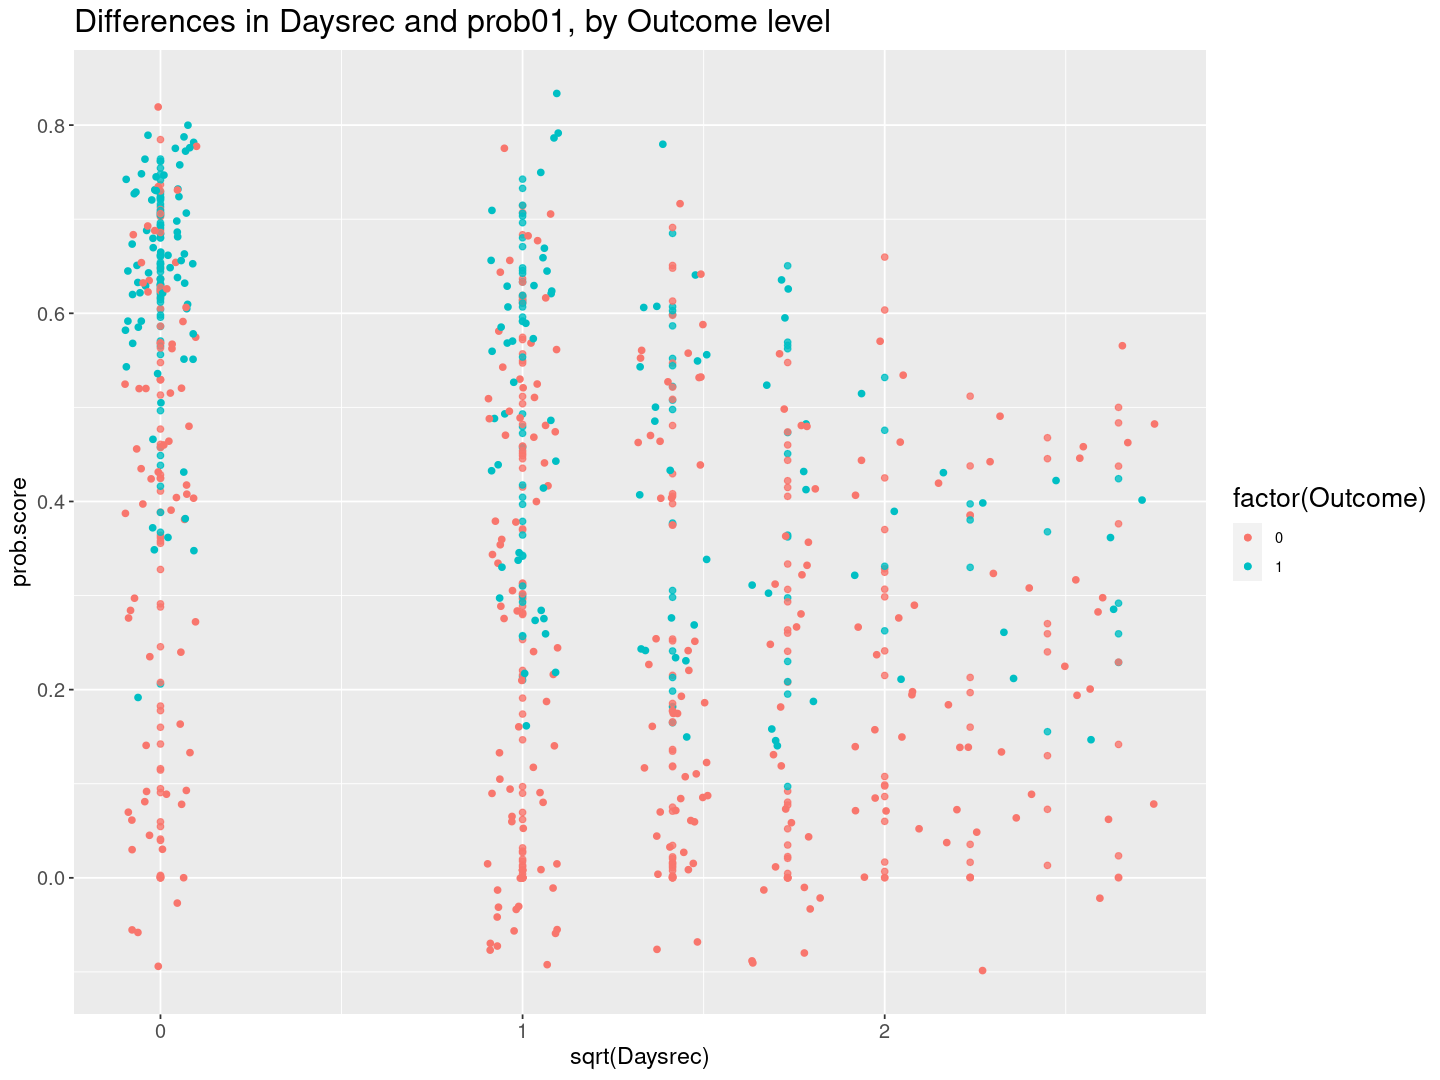

In [14]:
# Plot Daysrec vs. prob01.

dat_plot <- newtrain[, c("Outcome","Daysrec","prob01"), drop=FALSE]
dat_plot$Daysrec <- sqrt(dat_plot$Daysrec)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(Daysrec, prob01, color= factor(Outcome))) +

  geom_point(alpha= 0.8) + geom_jitter(width= 0.1, height= 0.1) +
  xlab("sqrt(Daysrec)") + ylab("prob.score") +
  ggtitle("Differences in Daysrec and prob01, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


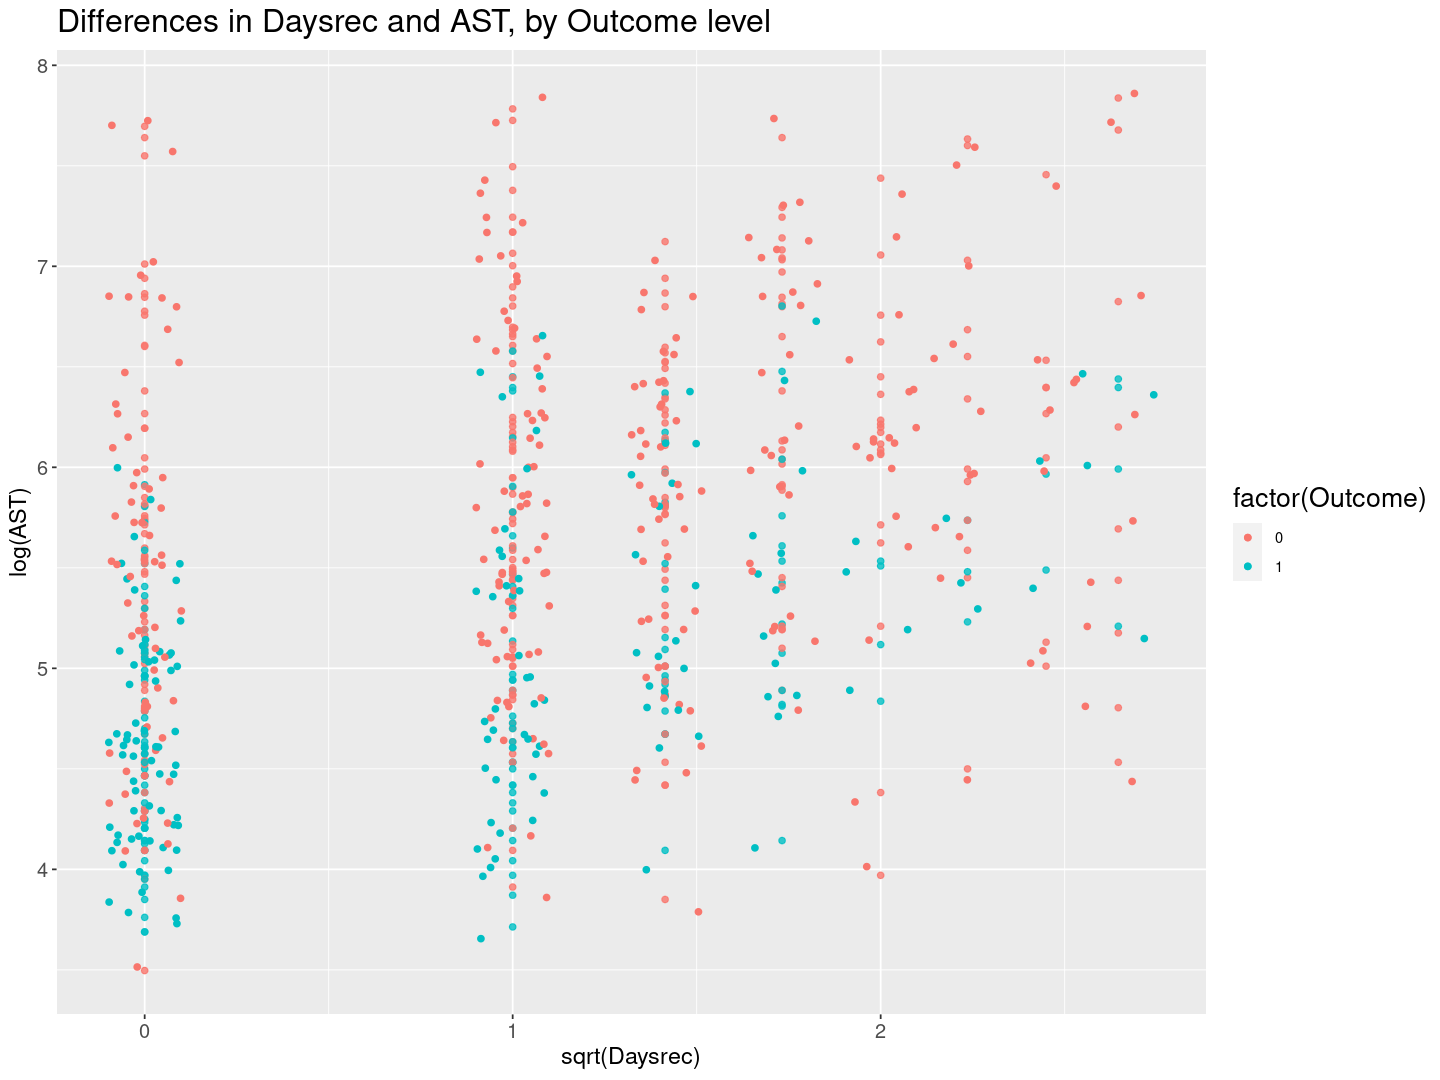

In [15]:
# Plot Daysrec vs. AST.

dat_plot <- newtrain[, c("Outcome","Daysrec","AST"), drop=FALSE]
dat_plot$Daysrec <- sqrt(dat_plot$Daysrec)
dat_plot$AST <- log(dat_plot$AST)

options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(Daysrec, AST, color= factor(Outcome))) +

  geom_point(alpha= 0.8) + geom_jitter(width= 0.1, height= 0.1) +
  xlab("sqrt(Daysrec)") + ylab("log(AST)") +
  ggtitle("Differences in Daysrec and AST, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p

# Postscript: Using tot.withinss to search for weights

When the k-means algorithm is applied to the data on downer cows, we ask the algorithm to give us 2 clusters because we are interested in only 2 clusters---distinguishing between the cows that survived and those that did not.  But we also see from the wss (within-group sum of squares) plot below, that a 2-cluster solution is optimal for our dataset regardless of our interest in distinguishing between survivors and non-survivors.  We might say that the dataset naturally lends itself to a 2-cluster solution.  This 2-cluster solution aligns fairly well with the Outcome levels due to the fact that the data in our dataframe was collected for the purpose of distinguishing between the survivors and the non-survivors.  

In this postscript, I explore whether we can find optimal weights for the columns used in our k-means modeling by measuring the total within-group sum of squares.  In other words, can weights be optimized by minimizing the total within-group sum of squares?  If so, then we have another way to find optimal weights.  With the current dataset, this second approach is 7X faster than the first.  Thus, if it works, it will a method we may sometimes want to use when searching for optimal weights.  (It will not always be 7X faster.  This factor depends on the dataset and what we are trying to do with it.)


                                   * * * * *

In [15]:
# The following function is from Robert Kabacoff's "R in Action", pp.379-380.

wssplot <- function(data, title="", nc=15, seed=1233) {
    
    # wss[1] is just the total sum of squares when 
    # there is only one center.
    wss <- (nrow(data) - 1)*sum(apply(data, 2, var))
    for(i in 2:nc) {
        set.seed(seed)
        wss[i] <- sum(kmeans(data, centers=i, 
                             iter.max = 50, nstart = 25)$withinss)
    }
    plot(1:nc, wss, type='b', xlab="Number of clusters",
        ylab="Within groups sums of squares",
        main= title)
}


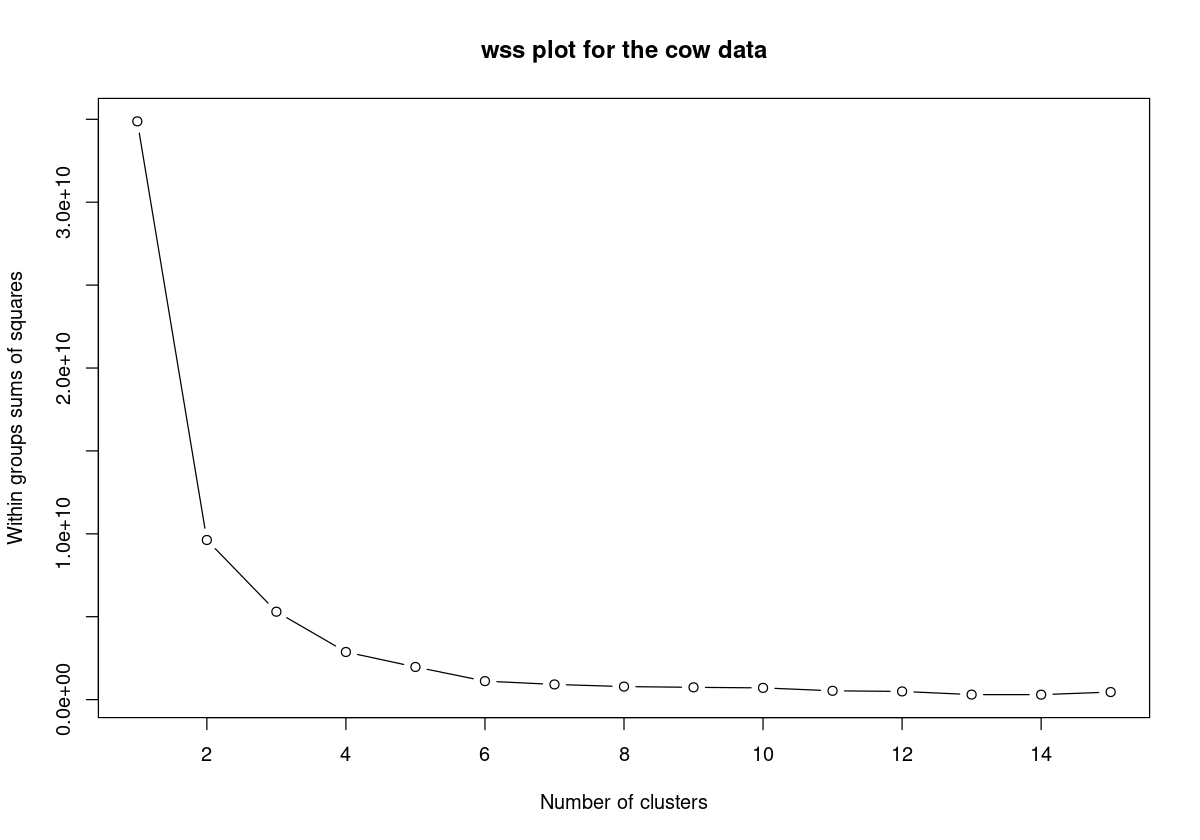

In [17]:
options(repr.plot.width= 10, repr.plot.height= 7)

# Remove the Outcome column from data before plotting.
wssplot(dat[, -1], title= "wss plot for the cow data")


In [ ]:
### COMMENT (on above graph):

# The largest gain we see in the reduction of within-group 
# sum of squares occurs when we have 2 clusters.  This 
# strongly suggests a 2-cluster solution to the 400 
# observations in dat.  The additional gain we would 
# get from a 3-cluster solution is negligible relative to
# the gain we see from a 2-cluster solution.  Thus, a 
# 2-cluster solution looks to be optimal for the downer 
# cow data.  Anything beyond 2 clusters will not be very
# helpful toward identifying the important groups in the
# dataset.

# Another way of describing how we use the above plot:
# we look for a "kink" in the curve; if there is one,
# that is the point at which we have an optimal number
# of clusters for the data we are working with.  See
# p. 513 of The Elements of Statistical Learning, 2nd
# Edition.


In [18]:
# Transform the data as if modeling for k-means.

df <- dat

g03 <- glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= df, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50)
    
df$prob01 <- as.numeric(g03$fitted)   
df$AST <- log(df$AST)
df$CK <- log(df$CK)
df$Daysrec <- sqrt(df$Daysrec)

df_scaled <- scale(df[, -1], center=TRUE, scale=TRUE)
df_scaled <- as.data.frame(cbind(df$Outcome, df_scaled),
                           row.names=rownames(df))
colnames(df_scaled) <- colnames(df)


# The following weights are those found in the above
# grid search for the hybrid model, kmp1_g03.
wghts <- c(0.14, 0.40, 0.19, 0.27)^0.5
names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    
df2 <- t(t(df_scaled[, cols]) * as.numeric(wghts[cols]))
df_wghts <- cbind(as.numeric(df_scaled$Outcome), df2)
df_wghts <- as.data.frame(df_wghts)
colnames(df_wghts) <- c("Outcome", cols)
rownames(df_wghts) <- rownames(df_scaled)


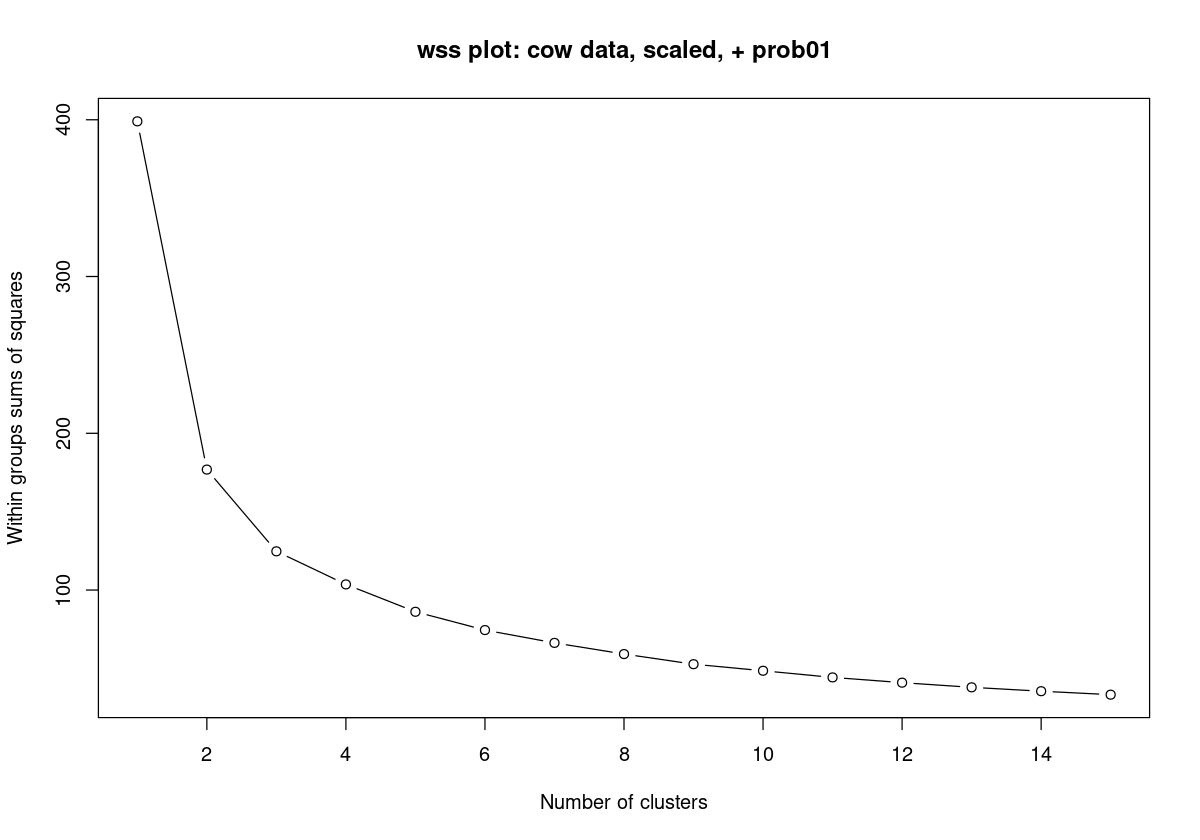

In [19]:
options(repr.plot.width= 10, repr.plot.height= 7)

# Remove the Outcome column from data before plotting.
wssplot(df_wghts[, -1], title= "wss plot: cow data, scaled, + prob01")


## Can we use tot.withinss to help us find the best set of weights?

The best weights are those which enable the k-means model to do the best job generalizing to new data.  Thus, our method will need to involve cross-validation.  Again, this means we are in the realm of supervised learning.



I want to see if this approach to finding weights works and, if so, whether it is a faster way to find optimal weights.


                                    * * * * *
                                    
                                    
It turns out that the weights we get using this approach depend very much on the scaling of the variables.  Below I apply a min-max scaling *after* centering and scaling each of the variables.  The mins and maxs from the training set should *not* be used for the scaling of the validation data.  With this dataset, doing so will not get us usable weights.

In [21]:
# Function for computing the tot.withinss for each set of 
# weights in df_params (a dataframe, each row of which is
# a candidate set of weights).  The optimal set of weights
# will be the set that yields the smallest average (over
# the folds) for tot.withinss.

# This function is called from gridSearch07.

get_tot.withinss_g03 <- function(traindat, valdat, wghts) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    # Scale training set data.  We need 'centers' and 'scales'
    # for scaling valdat.
    df <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(df, "scaled:center")
    scales <- attr(df, "scaled:scale")
    df <- as.matrix(df)
    traindat_scaled <- apply(df, MARGIN=2, range01)
    colnames(traindat_scaled) <- colnames(traindat)[-1]
    rownames(traindat_scaled) <- rownames(traindat)
    
    # Get mins and maxs for scaling of valdat.
    # traindat_mins <- as.numeric(apply(df, MARGIN=2, min))
    # traindat_maxs <- as.numeric(apply(df, MARGIN=2, max))
    
     
    #############################
    # Transform and scale valdat.
    
    valdat$prob01 <- as.numeric(predict(g03mod, newdata=valdat))
    
    df02 <- scale(valdat[, -1], center=centers, scale=scales)
    df02 <- as.matrix(df02)
    # df02_t <- t(as.matrix(df02))
    # df02_asList <- split(df02_t, seq(nrow(df02_t)))
    # names(df02_asList) <- colnames(valdat)[-1]

    # valdat_scaled <- mapply(range02, df02_asList, traindat_mins, 
    #                        traindat_maxs)
    
    valdat_scaled <- apply(df02, MARGIN=2, range01)
    # The next step is crucial.
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)[-1]
    
    # Apply weights to valdat.
    cols <- names(wghts)
    valdat_wghts <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    
    # Construct k-means model on valdat to get tot.withinss.
    kmod <- suppressWarnings(kmeans(valdat_wghts, 2, iter.max = 50, nstart=25))
    
    return(kmod$tot.withinss)
}


In [17]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation score.
# Because our training set is so small---only 400 records---we
# need to run the gridSearch over many seeds.  Otherwise, we 
# will not get a meaningful result.

gridSearch07 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "tot.withinss")
    datout$row <- params_rows <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    
    #############################
    # Partition the data into folds.
    
    segment_size <- round(dim(dat)[1]/folds)
    diff <- dim(dat)[1] - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == dim(dat)[1])
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are tot.withinss 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            # stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            train_list <- test_list <- vector("list", length= folds)
        
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                # stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            scores <- mcmapply(get_tot.withinss_g03, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the tot.withinss
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the tot.withinss scores
    # obtained for each set of parameters in df_params.
    datout$tot.withinss <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


In [18]:
# There are 4 parameter lists to work with. 

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [19]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
# head(tst_params)


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 secs (for 10 rows, 11 seeds)


In [ ]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


In [ ]:
dfc01[best_params,]

best_tot.withinss


In [25]:
# Find the best weights of those in dfc01 (1469 rows,
# 15 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 15, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- gridSearch07(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 10.6 - 13.2 mins  (= 0.341 secs/row)

# This is 7X faster than the first approach which 
# used cross-validation with the Type2 score.  


[1] "Start time: 2021-07-25 10:35:57"

Time difference of 13.17 mins

In [26]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [27]:
dfc01[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 26521  	0.13 	0.37	   0.13 	  0.37


best_tot.withinss
# 1.42


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
26521,0.13,0.37,0.13,0.37


[1] 1.4202

In [28]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.04, 0.14, by= 0.01)
lst[[2]] <- seq(0.36, 0.48, by= 0.01)
lst[[3]] <- seq(0.04, 0.14, by= 0.01)
lst[[4]] <- seq(0.36, 0.48, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  1091     4


[1] 1091    4

In [29]:
# Find the best weights of those in dfc02 (1091 rows,
# 15 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 15, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 10.2 mins


[1] "Start time: 2021-07-25 10:52:39"

Time difference of 10.2 mins

In [30]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [31]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 12717  	0.04 	0.48	   0.04 	  0.44

best_tot.withinss
# 0.92


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
12717,0.04,0.48,0.04,0.44


[1] 0.9184

In [32]:
# Of the 2 sets of weights identified, see which set does
# better when we use cross-validation with the Type2 score.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- 0.04
lst[[2]] <- 0.48
lst[[3]] <- 0.04
lst[[4]] <- 0.44

dfc02pt2 <- generate_combs(lst)

dfc02pt2 <- rbind(dfc02pt2, c(0.13, 0.37, 0.13, 0.37))

# Compare to the weights used for model kmp1_g03.
dfc02pt2 <- rbind(dfc02pt2, c(0.14, 0.40, 0.19, 0.27))
dfc02pt2


AST,CK,Daysrec,prob01
<dbl>,<dbl>,<dbl>,<dbl>
0.04,0.48,0.04,0.44
0.13,0.37,0.13,0.37
0.14,0.40,0.19,0.27


In [33]:
# Find the best weights of those in dfc02pt2 
# using 500 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 500, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, dfc02pt2) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.6 mins


Time difference of 5.59 mins

In [34]:
datout <- cbind(dfc02pt2, dat_result$Type2)
colnames(datout) <- c(colnames(dfc02pt2), "Type2")
datout


AST,CK,Daysrec,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.04,0.48,0.04,0.44,0.66055
0.13,0.37,0.13,0.37,0.66094
0.14,0.40,0.19,0.27,0.66175


In [ ]:
### COMMENTS:

# The Type2 score of the weights found in Section 4 is the
# highest score.  These are the weights used for the 
# kmp1_g03 model.  The next best weights are those first
# found using tot.withinss (2nd row in above table).

# Perhaps we can use tot.withinss for the first round or two 
# of the search for best weights and then finish the search
# relying on the Type2 score.  This is what I proceed to do
# in the cells that follow.  With the restricted range I have 
# chosen for dfc03, we should settle on nearly the same weights 
# we found in Section 4 (3rd row in the above table).


In [35]:
# Refine the search for weights, starting with the set
# initially found using tot.withinss.  Run cross-validation
# using Type2 scores.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.12, 0.18, by= 0.01)
lst[[2]] <- seq(0.36, 0.42, by= 0.01)
lst[[3]] <- seq(0.12, 0.18, by= 0.01)
lst[[4]] <- seq(0.36, 0.42, by=0.01)

dfc03 <- generate_combs(lst)
dim(dfc03)
#  35     4


[1] 35  4

In [36]:
# Find the best weights of those in dfc02 (35 rows,
# 51 seeds, 5 folds).  Note that I am using 51 seeds
# here rather than 11.

set.seed(1233)
seed_vector <- sample(1:9999, 51, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.45 mins


[1] "Start time: 2021-07-25 11:20:25"

Time difference of 6.45 mins

In [38]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [39]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 359    	0.13 	0.38	   0.12 	  0.37

best_Type2
# 0.6622


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
359,0.13,0.38,0.12,0.37


[1] 0.66219

## Summary info-2 for hybrid model with prob01 constructed from g03

First change get_cvInfo to call the function in the next cell.

In [40]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column, but with
# the weights found above using tot.withinss.

get_cvScores_kmp1_g03_v02 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    #############################
    # Transform and scale training set data.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  
    
    # These are the most recents weights we have found.
    wghts <- c(0.13, 0.38, 0.12, 0.37)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- predict(g03mod, newdata=valdat)
    valdat$prob01 <- as.numeric(preds01_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [42]:
# Get scores for the hybrid model with prob01 constructed 
# from the g03 logistic model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.53 mins


Time difference of 3.55 mins

In [43]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.4898,0.6875,0.5689,20,5
4782--2,0.6667,0.8000,0.7200,8,8
4782--3,0.6667,0.7125,0.6850,13,10
4782--4,0.6774,0.7500,0.7064,10,10
4782--5,0.6182,0.7375,0.6659,9,12
9275--1,0.6296,0.7500,0.6778,13,7


In [44]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6134
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0673
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6134"

[1] "fscore StdDev: 0.0673"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.323   0.571   0.615   0.613   0.656   0.815 

In [45]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7320
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0440
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.732"

[1] "accuracy StdDev: 0.044"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.575   0.700   0.738   0.732   0.762   0.875 

In [46]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6609
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0553
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6609"

[1] "Type2 StdDev: 0.0553"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.440   0.623   0.662   0.661   0.698   0.839 

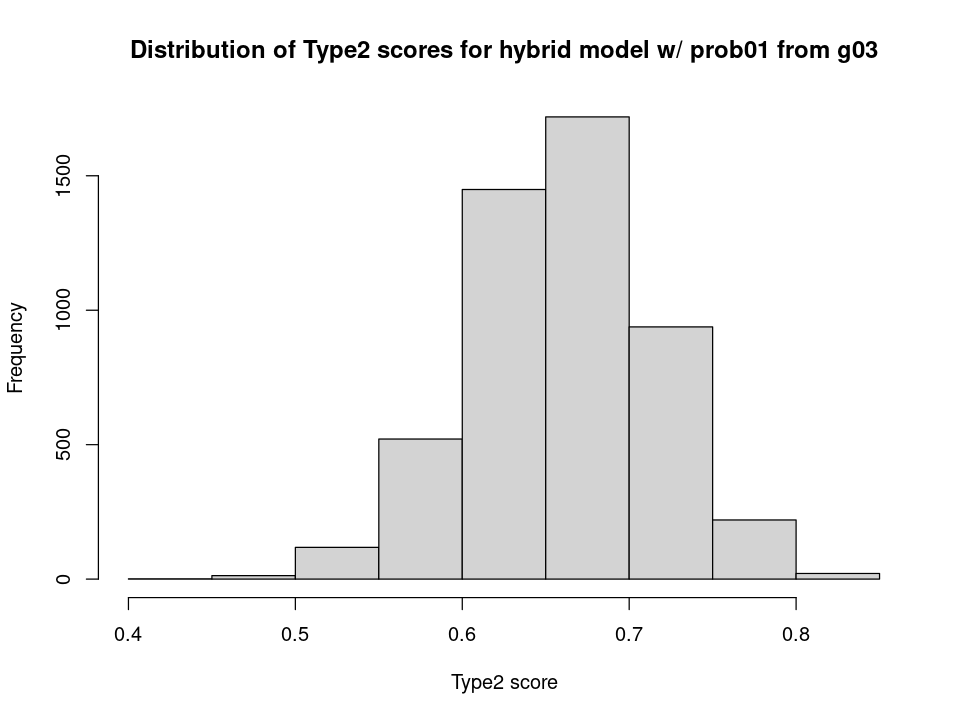

In [47]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 8, repr.plot.height= 6)
hist(dat_result$Type2, breaks=14, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ prob01 from g03")


In [48]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.59
paste0("FN StdDev: ", as.character(FN_sd))
# 3.20
""
summary(dat_result$FN)


[1] "FN mean: 12.589"

[1] "FN StdDev: 3.1972"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    10.0    13.0    12.6    15.0    25.0 

In [49]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 8.85
paste0("FP StdDev: ", as.character(FP_sd))
# 3.01
""
summary(dat_result$FP)


[1] "FP mean: 8.8488"

[1] "FP StdDev: 3.0077"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    7.00    9.00    8.85   11.00   21.00 

## Summary table, including most recent results

In [50]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part1_Addendum.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  6 10

In [51]:
# The most recent results are the last line in the table.
# The results for kmp1_g03v02 are essentially the same as
# those for kmp1_g03.

results


,fscore,fscore_sd,accuracy,acc_sd,Type2,Type2_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g03,0.6183,0.0646,0.7167,0.0448,0.6577,0.0543,11.24,3.04,11.43,3.34
gbclf,0.6051,0.0665,0.7135,0.0448,0.6485,0.0552,12.03,3.23,10.89,3.29
svm02,0.6320,0.0628,0.7030,0.0472,0.6604,0.0542,14.53,3.63,9.23,3.16
km_wghts,0.6348,0.0620,0.7004,0.0462,0.6610,0.0532,8.72,2.46,15.25,3.14
kmp1_g03,0.6163,0.0676,0.7298,0.0443,0.6617,0.0556,12.22,3.06,9.40,3.00
kmp1_g03v02,0.6134,0.0673,0.7320,0.0440,0.6609,0.0553,12.59,3.20,8.85,3.01


## Final Comments for the Postscript

This Postscript section shows how we can make use of tot.withinss when searching for optimal weights.  This second approach to finding weights is more efficient than directly relying upon Type2 cross-validation scores.

However, more research needs to be done on this approach to finding weights.  As we saw above, I could not rely on it through the entire process of finding weights; it looks to be useful only for the initial grid search.  The method of using tot.withinss is very sensitive to how we scale the data.  Without the right scaling, the grid search takes us down the wrong path.  Of course, before we go to far, we can run a check on the weights using Type2 (or accuracy) cross-validation scores.

